In [289]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [290]:
!pip install tensorflow

In [291]:
import tensorflow as tf

In [292]:
!pip install keras

In [293]:
!pip install scikeras

In [294]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [295]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [296]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [297]:
!pip install shap
import shap

In [298]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [299]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [300]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [301]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [302]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [303]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users_with_country_2"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [304]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [305]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 2500),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 2500)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [306]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [307]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  2500
Number of bots:  2500


In [308]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [309]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [310]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  2500
Number of human users:  2500


## Data preparation

In [311]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [312]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [313]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [314]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True False]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [315]:
column_to_remove

['withheld']

In [316]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [317]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


### Location mapping

#### Tried some supporting libs:
    - pycountry.countries.search_fuzzy: working not too good with some basic locations 
    - locationtagger: working not too good with some basic locations 
    - geograpy.get_place_context: chosen tool to map location to country
    
Chosen **geograpy3 lib** - mapping moved to preprocessing step - added new columns 'country' and 'country_numeric'

In [318]:
import json
 
with open('./../../data-preprocessing/scripts/users/countries_dict.json') as json_file:
    country_dict = json.load(json_file)

#### Null and NaN statistics

In [319]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 1388
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0
country: 0
country_numeric: 0


#### Extract some information from dataframe to new columns

##### Description length

In [320]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [321]:
from datetime import datetime

In [322]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [323]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [324]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description", 'country']
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

id  label  verified  protected  has_location  \
0               556802835      1         0          0             1   
1      935946794340638721      0         0          0             1   
2                19480507      1         0          0             1   
3      784426574372282368      0         0          0             1   
4                17964282      1         0          0             1   
...                   ...    ...       ...        ...           ...   
4995             82763111      0         1          0             1   
4996            119523370      1         0          0             1   
4997           1627875162      0         0          0             1   
4998  1113332447356309505      1         0          0             1   
4999             19949762      0         1          0             1   

      has_profile_image_url  has_pinned_tweet  followers_count  \
0                         1                 0           2865.0   
1                         1                 1            571.0   
2                         1                 0             74.0   
3                         1                 0             88.0   
4                         1                 0             69.0   
...                     ...               ...              ...   
4995                      1                 0          10803.0   
4996                      1                 0            155.0   
4997                      1                 0           7286.0   
4998                      1                 0            257.0   
4999                      1                 1           1691.0   

      following_count  tweet_count  listed_count  has_description  \
0              4604.0       4149.0          33.0                1   
1               407.0       4171.0           0.0                0   
2               106.0        286.0           2.0                1   
3                63.0         11.0           1.0                1   
4               155.0        164.0           4.0                0   
...               ...          ...           ...              ...   
4995            244.0       3267.0         401.0                1   
4996            912.0        316.0           1.0                1   
4997           1309.0       7338.0         181.0                1   
4998            214.0        129.0           2.0                1   
4999           1000.0        539.0         114.0                1   

      descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
0                   5.0                0.0                0.0            0.0   
1                   0.0                0.0                0.0            0.0   
2                   0.0                0.0                0.0            0.0   
3                   0.0                0.0                0.0            0.0   
4                   0.0                0.0                0.0            0.0   
...                 ...                ...                ...            ...   
4995                0.0                0.0                0.0            0.0   
4996                1.0                0.0                0.0            0.0   
4997                0.0                0.0                0.0            0.0   
4998                0.0                0.0                0.0            1.0   
4999                0.0                0.0                0.0            0.0   

      url_no_urls  country_numeric  descr_len  account_age  
0             0.0            106.0      148.0       3619.0  
1             0.0              1.0        0.0       1568.0  
2             0.0            106.0       62.0       4798.0  
3             0.0             80.0       92.0       1986.0  
4             0.0             41.0        0.0       4846.0  
...           ...              ...        ...          ...  
4995          1.0            139.0      145.0       4534.0  
4996          0.0             81.0       50.0       4396.0  
4997          1.0            139.0    

### Data type conversion (to float)

In [325]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [326]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [327]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [328]:
train_data.describe()

id        label     verified    protected  has_location  \
count  3.500000e+03  3500.000000  3500.000000  3500.000000   3500.000000   
mean   5.275656e+17     0.507143     0.044000     0.002000      0.720857   
std    6.031933e+17     0.500020     0.205124     0.044683      0.448642   
min    3.570000e+02     0.000000     0.000000     0.000000      0.000000   
25%    2.898877e+08     0.000000     0.000000     0.000000      0.000000   
50%    3.279254e+09     1.000000     0.000000     0.000000      1.000000   
75%    1.160786e+18     1.000000     0.000000     0.000000      1.000000   
max    1.494694e+18     1.000000     1.000000     1.000000      1.000000   

       has_profile_image_url  has_pinned_tweet  followers_count  \
count            3500.000000       3500.000000     3.500000e+03   
mean                0.999714          0.219143     6.208113e+03   
std                 0.016903          0.413725     4.961779e+04   
min                 0.000000          0.000000     0.000000e+00   
25%                 1.000000          0.000000     3.500000e+01   
50%                 1.000000          0.000000     2.890000e+02   
75%                 1.000000          0.000000     1.529500e+03   
max                 1.000000          1.000000     1.505591e+06   

       following_count    tweet_count  listed_count  has_description  \
count      3500.000000    3500.000000   3500.000000      3500.000000   
mean       1381.465429    5252.430857     81.374000         0.806000   
std        8732.753426   22847.105934    354.741687         0.395485   
min           0.000000       0.000000      0.000000         0.000000   
25%          71.000000      26.000000      0.000000         1.000000   
50%         264.000000     536.000000      4.000000         1.000000   
75%         876.000000    3056.750000     38.000000         1.000000   
max      383867.000000  497641.000000   9109.000000         1.000000   

       descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
count        3500.000000        3500.000000        3500.000000    3500.000000   
mean            0.390857           0.001714           0.336571       0.082000   
std             1.316602           0.058537           0.894478       0.324949   
min             0.000000           0.000000           0.000000       0.000000   
25%             0.000000           0.000000           0.000000       0.000000   
50%             0.000000           0.000000           0.000000       0.000000   
75%             0.000000           0.000000           0.000000       0.000000   
max            16.000000           3.000000           8.000000       4.000000   

       url_no_urls  country_numeric    descr_len  account_age  
count  3500.000000      3500.000000  3500.000000  3500.000000  
mean      0.578571        73.364286    86.111429  2485.641714  
std       0.493858        82.239424    59.732586  1619.691615  
min       0.000000         1.000000     0.000000    26.000000  
25%       0.000000         1.000000    26.750000   947.000000  
50%       1.000000        41.000000    98.000000  2462.500000  
75%       1.000000       112.000000   144.000000  3974.000000  
max       1.000000       250.000000   243.000000  5747.000000

# Data analysis

In [329]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [330]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [331]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot  1775
1  Validation data    Bot   354
2        Test data    Bot   371
3    Training data  Human  1725
4  Validation data  Human   396
5        Test data  Human   379

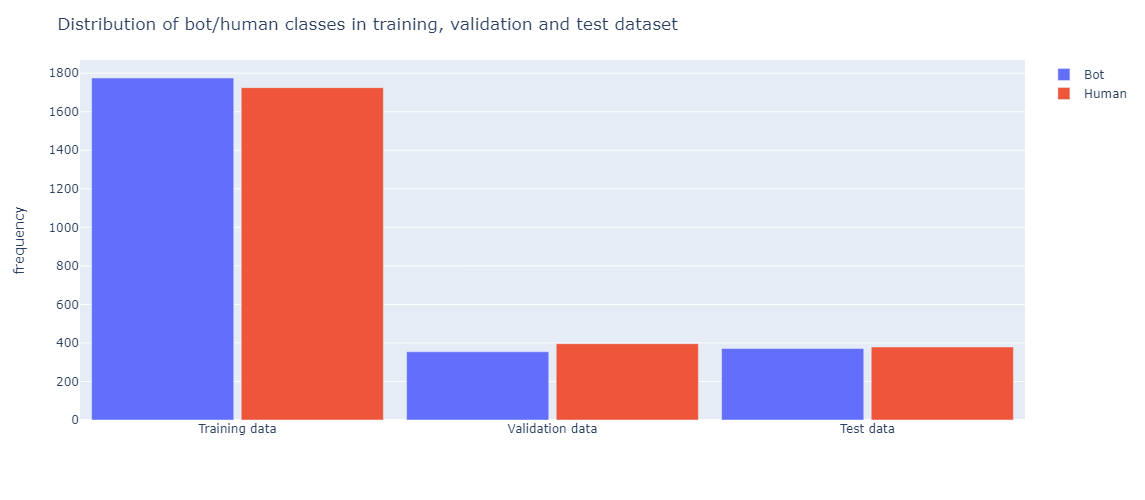

In [332]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']

In [333]:
train_bot_data = train_data.loc[train_data['label']==1]
train_human_data = train_data.loc[train_data['label']==0]

# stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']*4,
#     'Label': ['Bot']*12 + ['Human']*12,
#     'Value': [True]*6 + [False]*6 + [True]*6 + [False]*6,
stack_bool_training_feature_data = {'Feature': ['verified', 'has_pinned_tweet', 'has_description']*4,
    'Label': ['Bot']*6 + ['Human']*6,
    'Value': [True]*3 + [False]*3 + [True]*3 + [False]*3,
    'Freq': [len(train_bot_data.loc[train_bot_data['verified']==1]), 
             # len(train_bot_data.loc[train_bot_data['protected']==1]), 
             # len(train_bot_data.loc[train_bot_data['has_location']==1]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==1]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==1]), 
             len(train_bot_data.loc[train_bot_data['has_description']==1]),
             len(train_bot_data.loc[train_bot_data['verified']==0]), 
             # len(train_bot_data.loc[train_bot_data['protected']==0]), 
             # len(train_bot_data.loc[train_bot_data['has_location']==0]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==0]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==0]), 
             len(train_bot_data.loc[train_bot_data['has_description']==0]),
             len(train_human_data.loc[train_human_data['verified']==1]), 
             # len(train_human_data.loc[train_human_data['protected']==1]), 
             # len(train_human_data.loc[train_human_data['has_location']==1]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==1]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==1]), 
             len(train_human_data.loc[train_human_data['has_description']==1]),
             len(train_human_data.loc[train_human_data['verified']==0]), 
             # len(train_human_data.loc[train_human_data['protected']==0]), 
             # len(train_human_data.loc[train_human_data['has_location']==0]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==0]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==0]), 
             len(train_human_data.loc[train_human_data['has_description']==0])]}

stack_training_bool_feature_df = pd.DataFrame(stack_bool_training_feature_data)

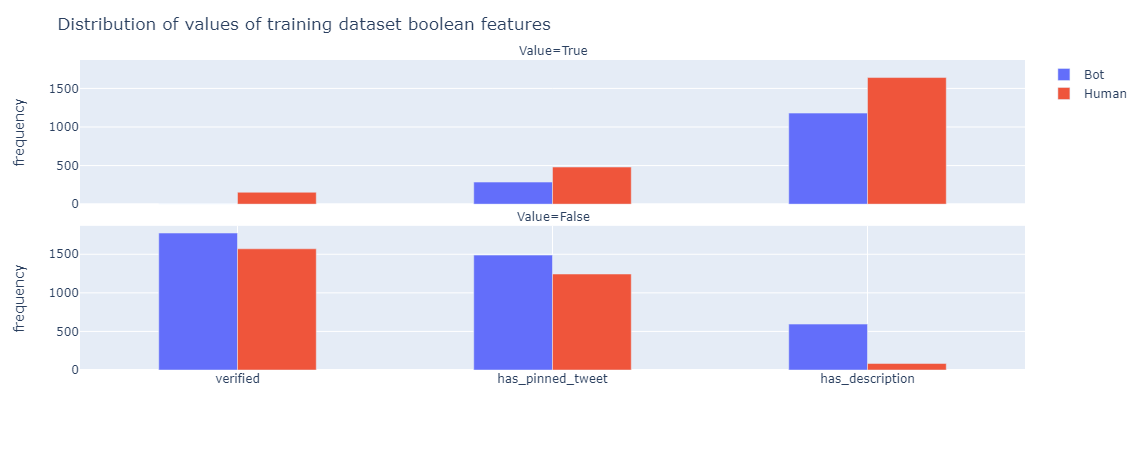

In [334]:
fig = px.bar(stack_training_bool_feature_df, 
               x="Feature", 
               y="Freq",
               facet_col="Value",
               facet_col_wrap = 1,
               color="Label", hover_data=['Label'],
               barmode = 'group')
fig.update_layout(
    title_text='Distribution of values of training dataset boolean features',
    xaxis_title_text='', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True))

fig.update_yaxes(row=2, col=1, title='frequency')
fig.show()

### followers_count

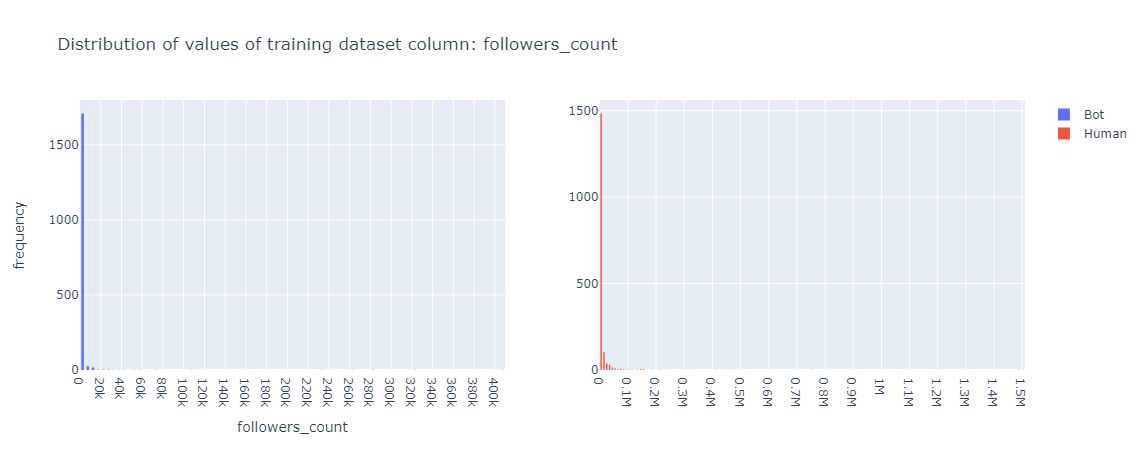

In [335]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  272


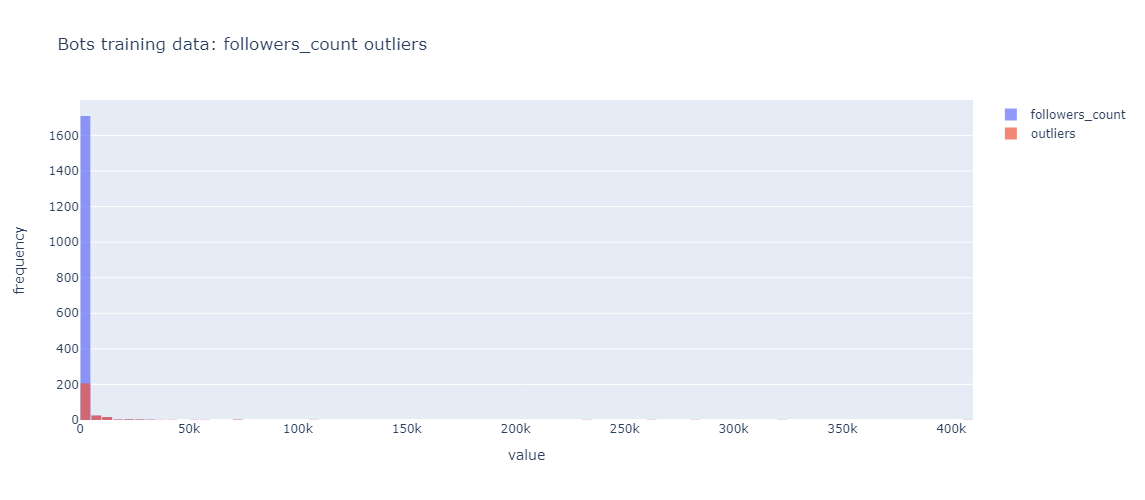

<Figure size 1500x700 with 0 Axes>

In [336]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  738


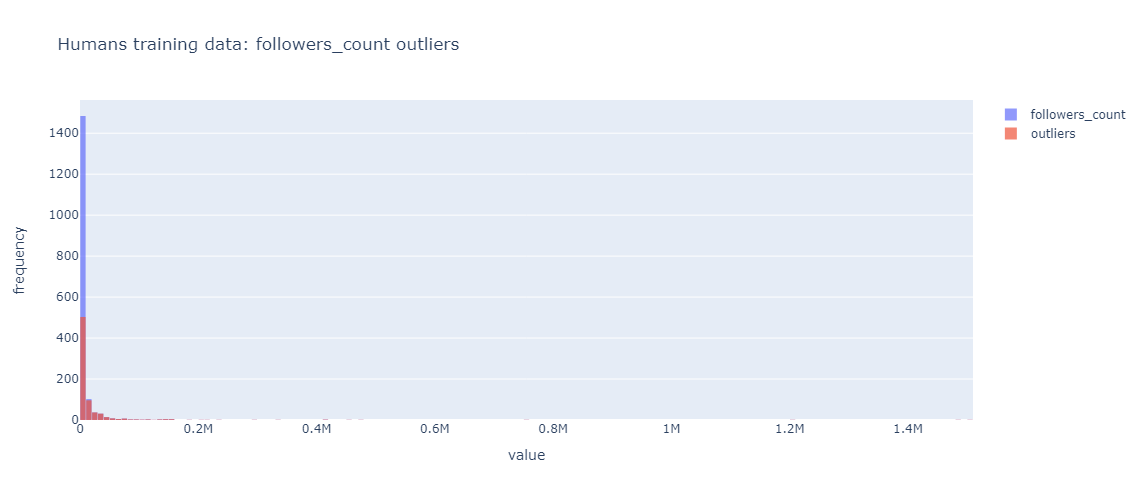

<Figure size 1500x700 with 0 Axes>

In [337]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [338]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [339]:
len(train_data[(train_data['label']==1)])

1775

In [340]:
len(train_data[(train_data['label']==0)])

1725

In [341]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [342]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [343]:
len(df_filtered_bots)

1728

In [344]:
len(df_filtered_humans)

1667

In [345]:
len(df_reduced_outliers_followers_count) 

3395

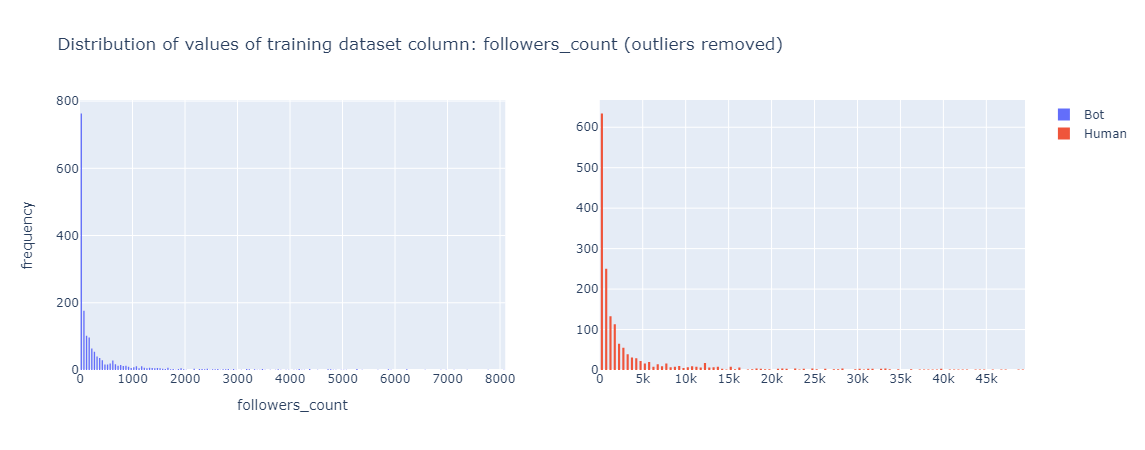

In [346]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

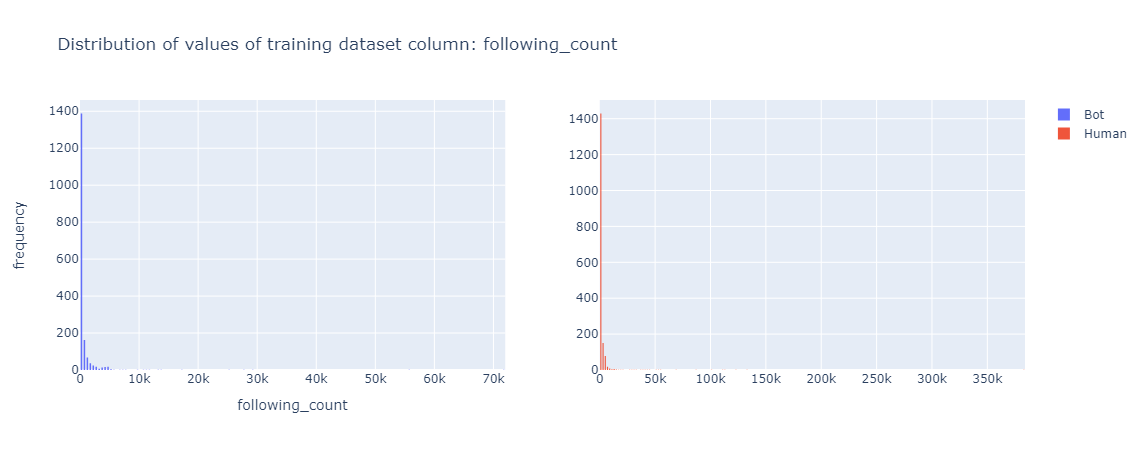

In [347]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000),
    xaxis2=dict(showgrid=True, dtick=50000),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [348]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

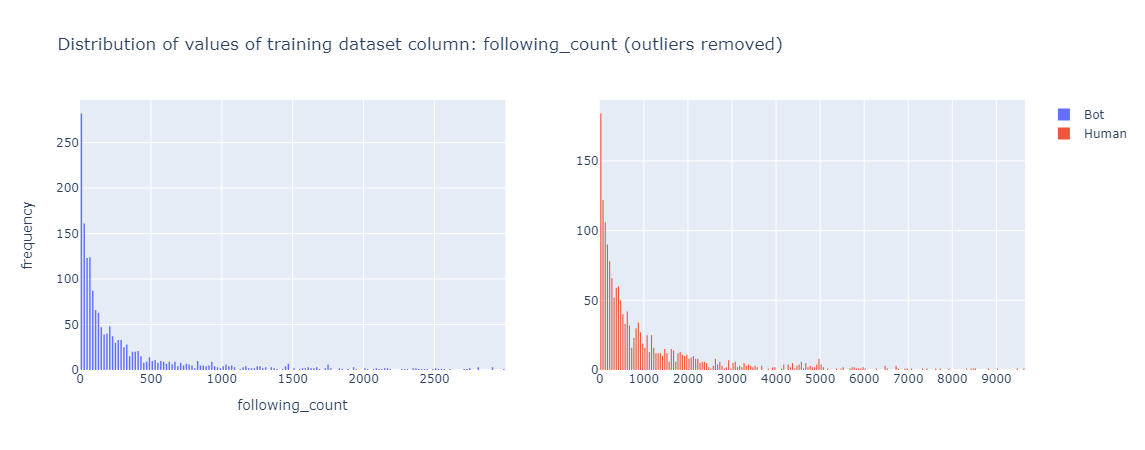

In [349]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500),
    xaxis2=dict(showgrid=True, dtick=1000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

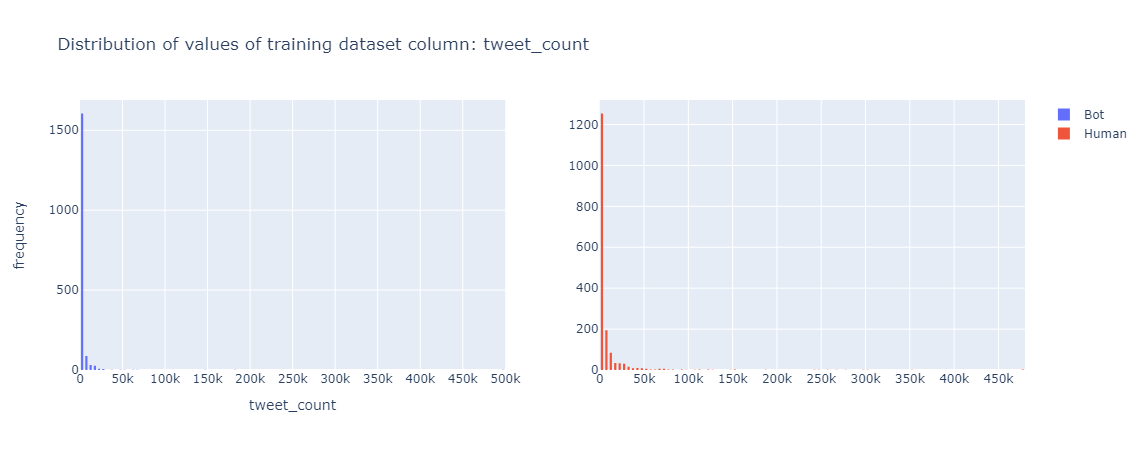

In [350]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=50000),
    xaxis2=dict(showgrid=True, dtick=50000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [351]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

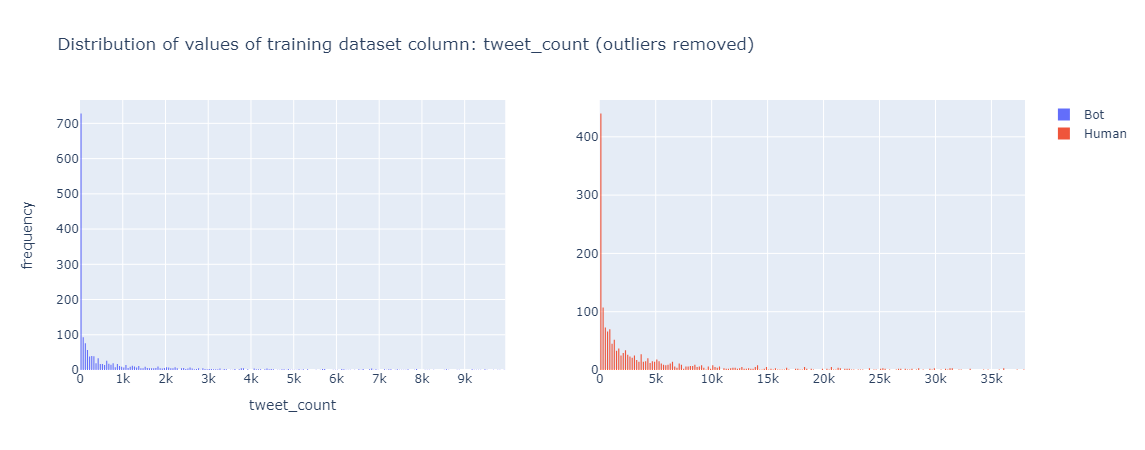

In [352]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000),
    xaxis2=dict(showgrid=True, dtick=5000),
    yaxis=dict(showgrid=True))

fig.show()

### listed_count

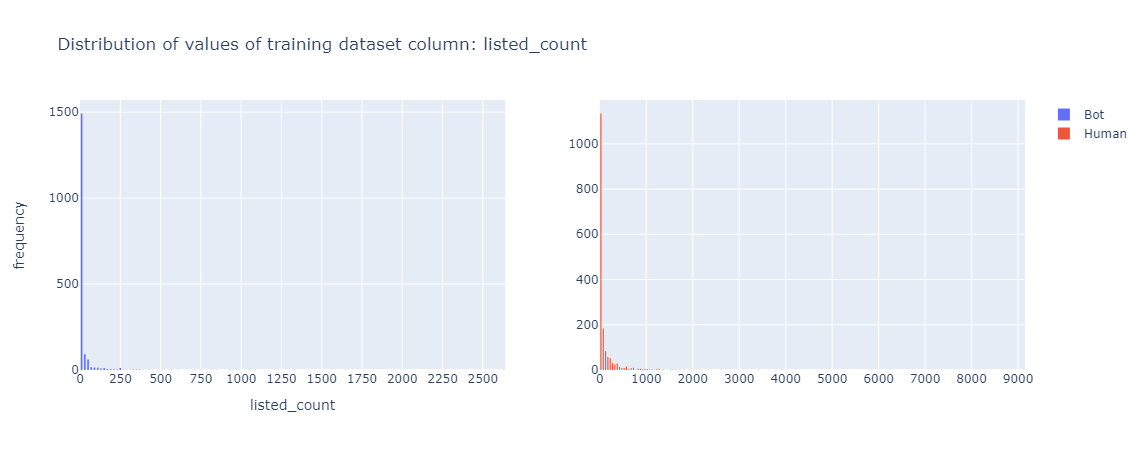

In [382]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=250),
    xaxis2=dict(showgrid=True, dtick=1000),
    yaxis=dict(showgrid=True))

fig.show()

#### listed_count - outliers

In [383]:
df_reduced_outliers_listed_count = df_99_percentile(df=train_data, column_name='listed_count')

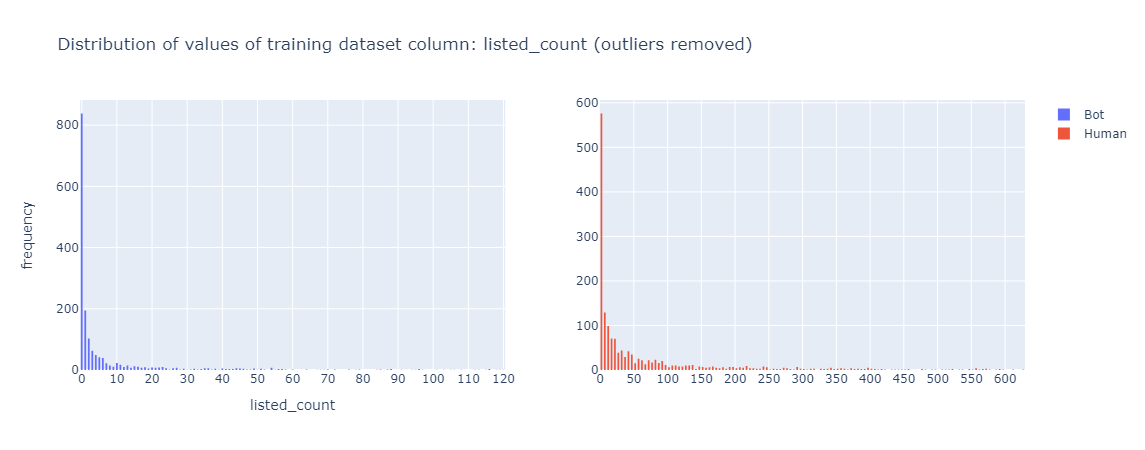

In [387]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count (outliers removed)',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=50),
    yaxis=dict(showgrid=True))

fig.show()

### ['descr_no_hashtags', 'descr_no_cashtags', 'descr_no_mentions', 'descr_no_urls', 'descr_len', 'url_no_urls']

### descr_no_hashtags

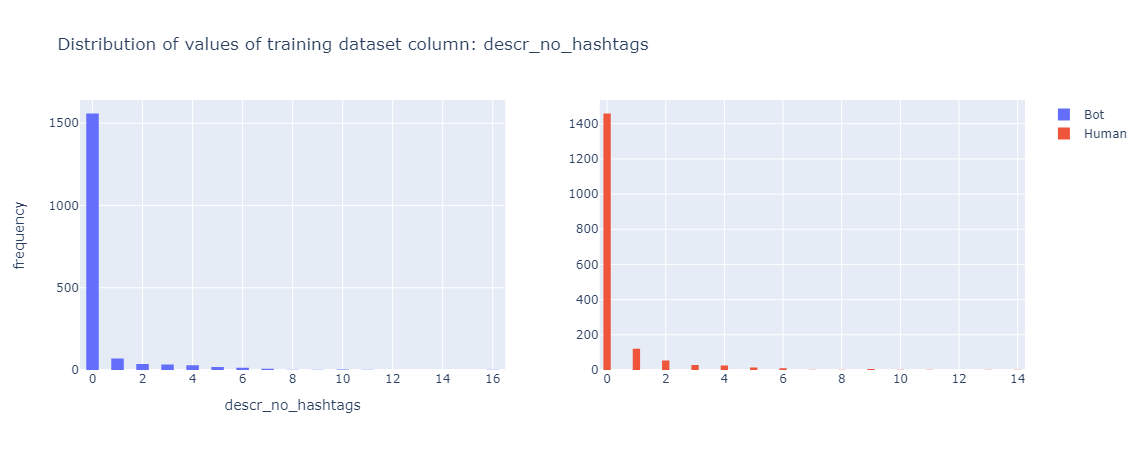

In [356]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=2),
    xaxis2=dict(showgrid=True, dtick=2),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_hashtags - outliers

In [357]:
df_reduced_outliers_descr_no_hashtags = df_99_percentile(df=train_data, column_name='descr_no_hashtags')

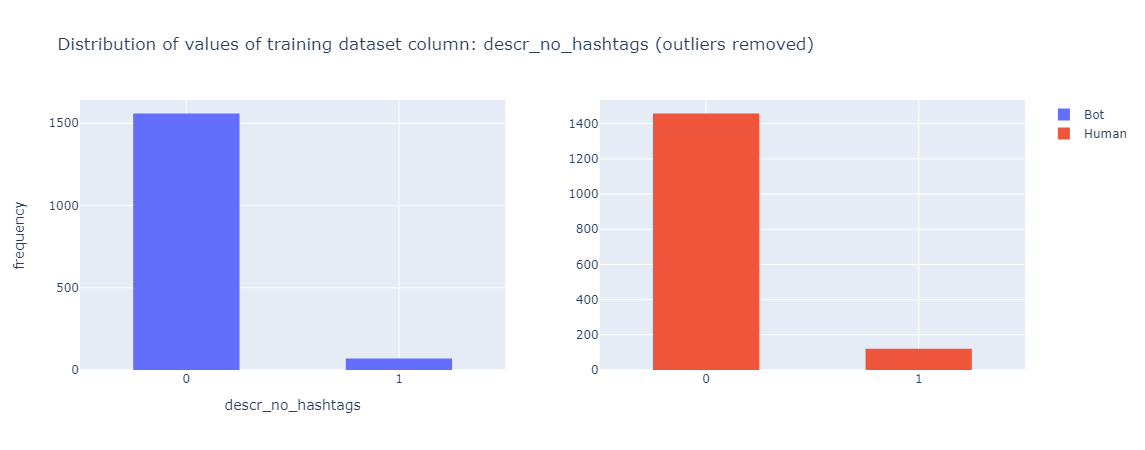

In [358]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags (outliers removed)',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_cashtags


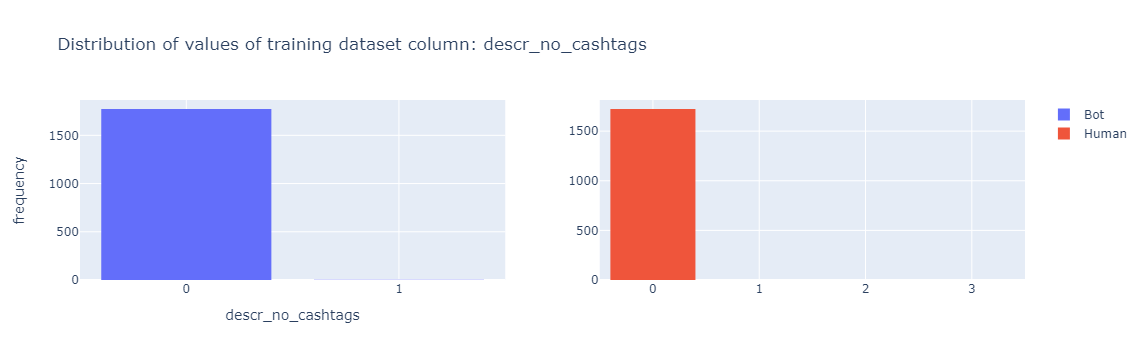

In [359]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_cashtags - outliers

In [360]:
df_reduced_outliers_descr_no_cashtags = df_99_percentile(df=train_data, column_name='descr_no_cashtags')

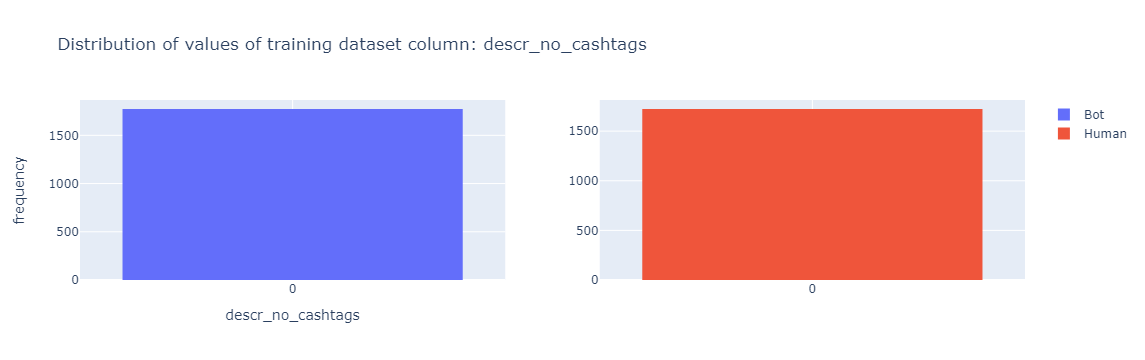

In [361]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### descr_no_mentions

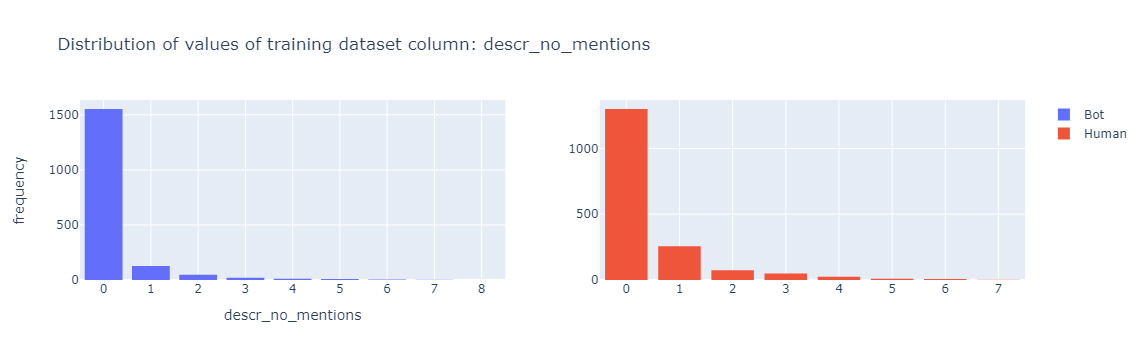

In [362]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_mentions - outliers

In [363]:
df_reduced_outliers_descr_no_mentions = df_99_percentile(df=train_data, column_name='descr_no_mentions')

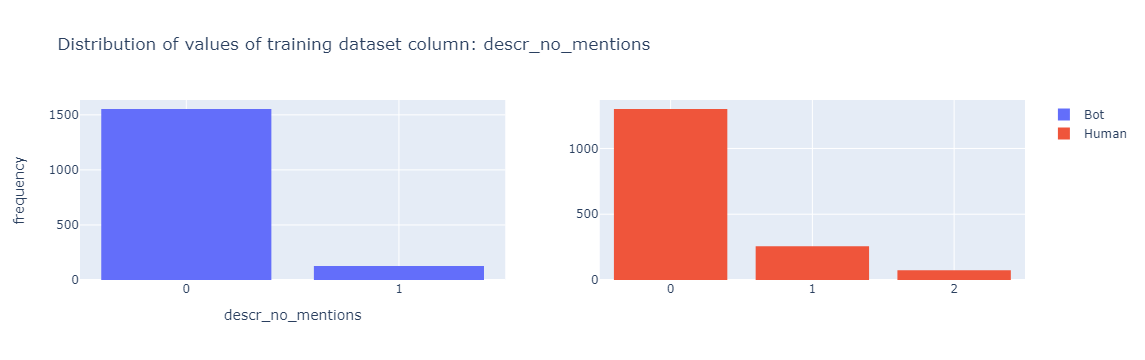

In [364]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_urls

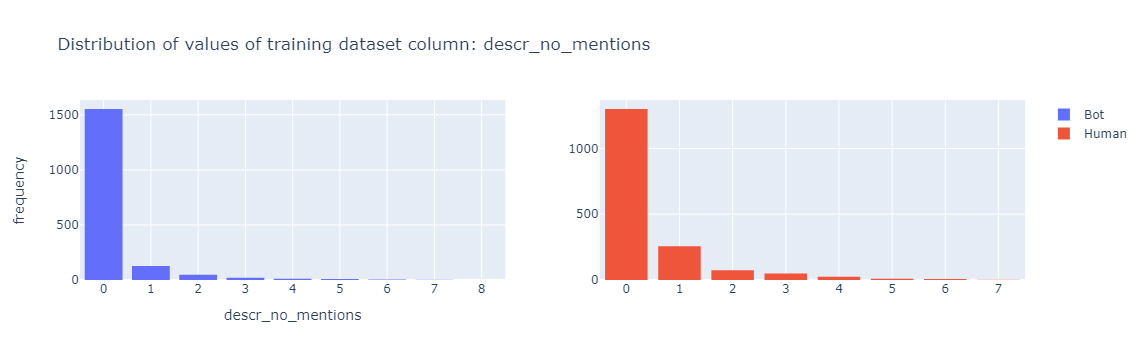

In [365]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_urls - outliers

In [366]:
df_reduced_outliers_descr_no_urls = df_99_percentile(df=train_data, column_name='descr_no_urls')

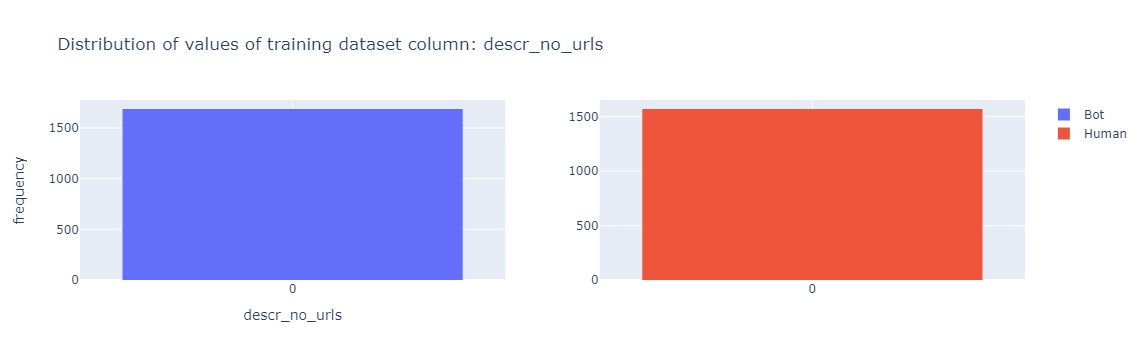

In [367]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==1,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==0,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_urls',
    xaxis_title_text='descr_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### url_no_urls

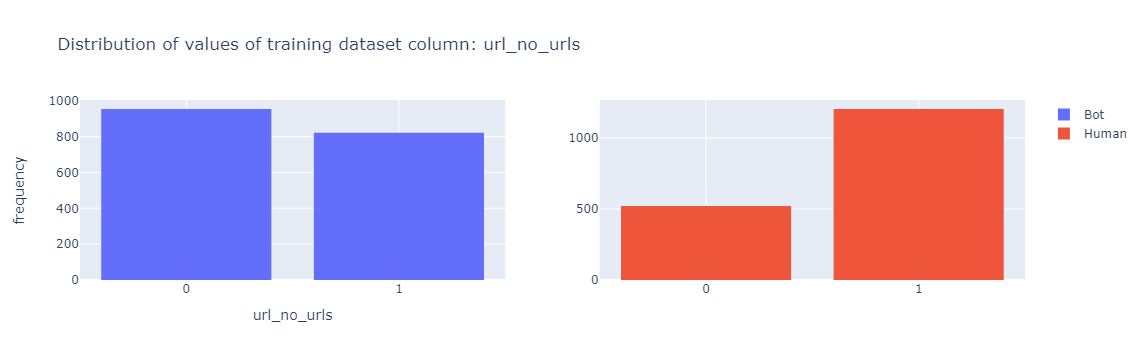

In [368]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### url_no_urls - outliers

In [369]:
df_reduced_outliers_url_no_urls = df_99_percentile(df=train_data, column_name='url_no_urls')

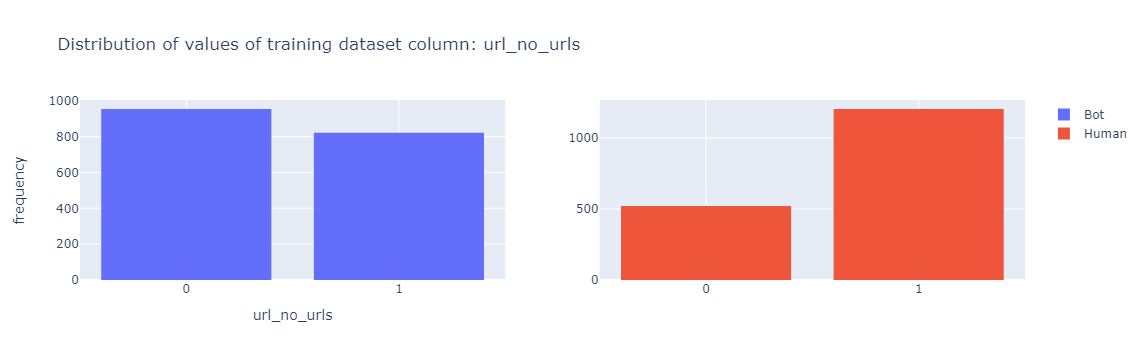

In [370]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

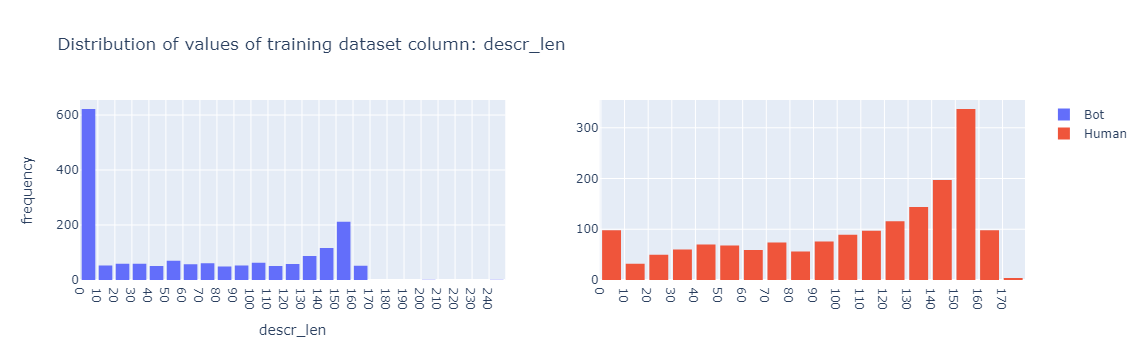

In [371]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [372]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

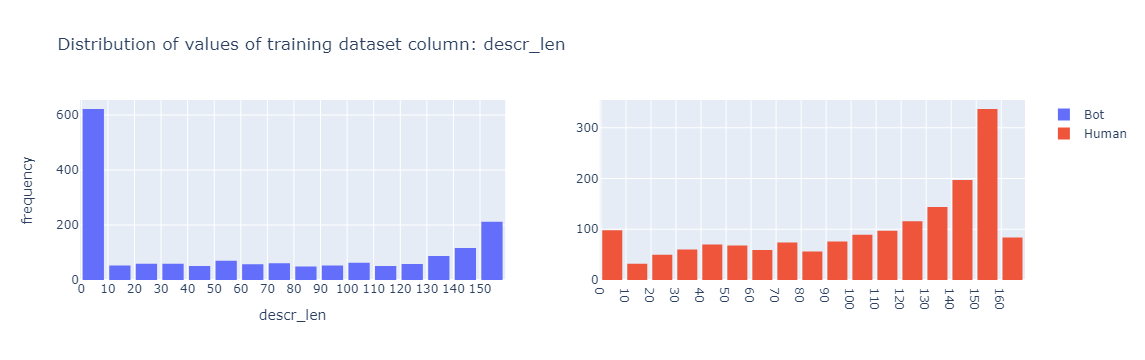

In [391]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

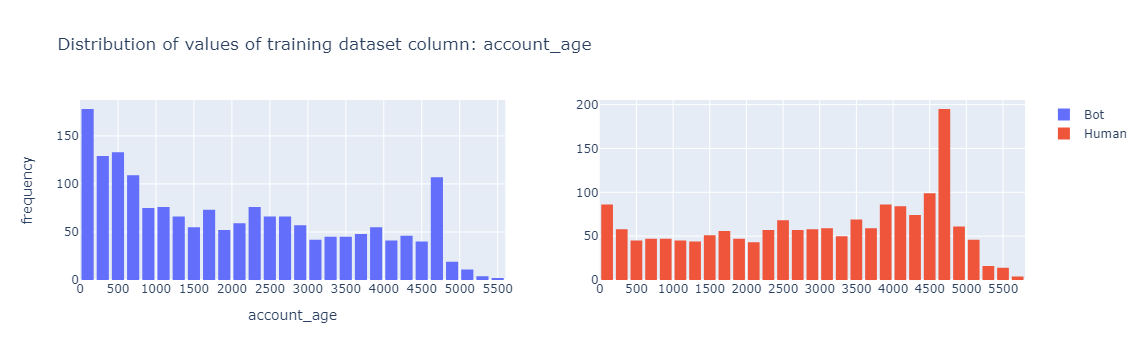

In [374]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500),
    xaxis2=dict(showgrid=True, dtick=500),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [375]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

### country_numeric

In [376]:
def map_contries_to_str(numeric_encoded_country_list):
    mapped_countries = []
    for i,row in enumerate(numeric_encoded_country_list):
        numeric_value = int(row)
        res = dict((v,k) for k,v in country_dict.items())
        mapped_countries.append(res[numeric_value])
    return mapped_countries

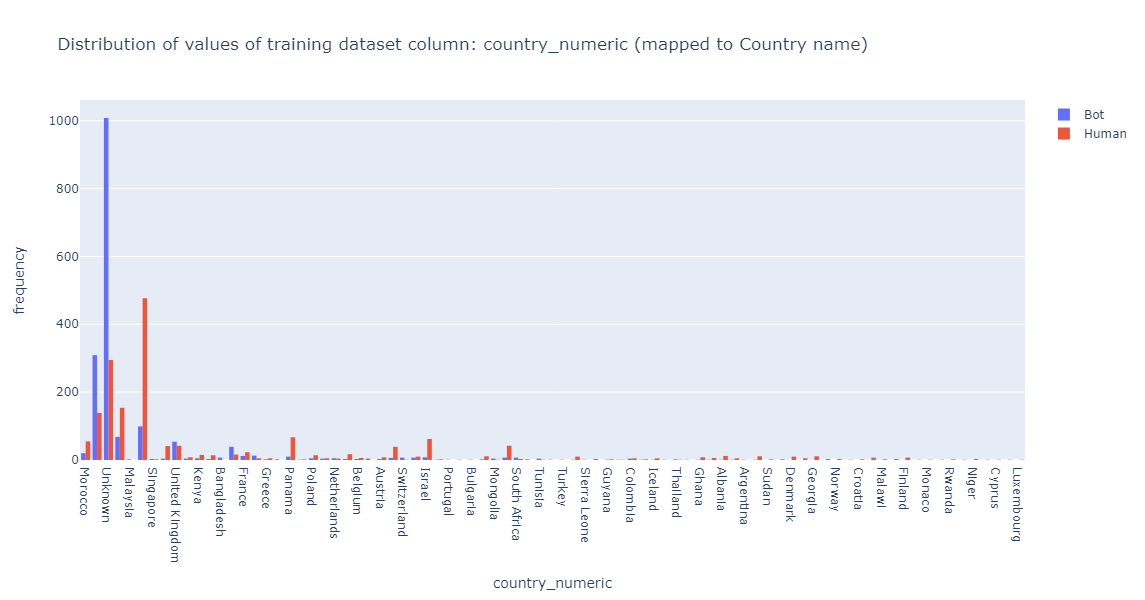

In [392]:
fig = go.Figure()
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=map_contries_to_str(train_data.loc[train_data['label']==1,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
# row=1, col=1
)
fig.add_trace(go.Histogram(
    x=map_contries_to_str(train_data.loc[train_data['label']==0,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
# row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: country_numeric (mapped to Country name)',
    xaxis_title_text='country_numeric', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1200,
    height=600,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=10),
    # xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### country_numeric - outliers

In [378]:
df_reduced_outliers_country_numeric = df_99_percentile(df=train_data, column_name='country_numeric')

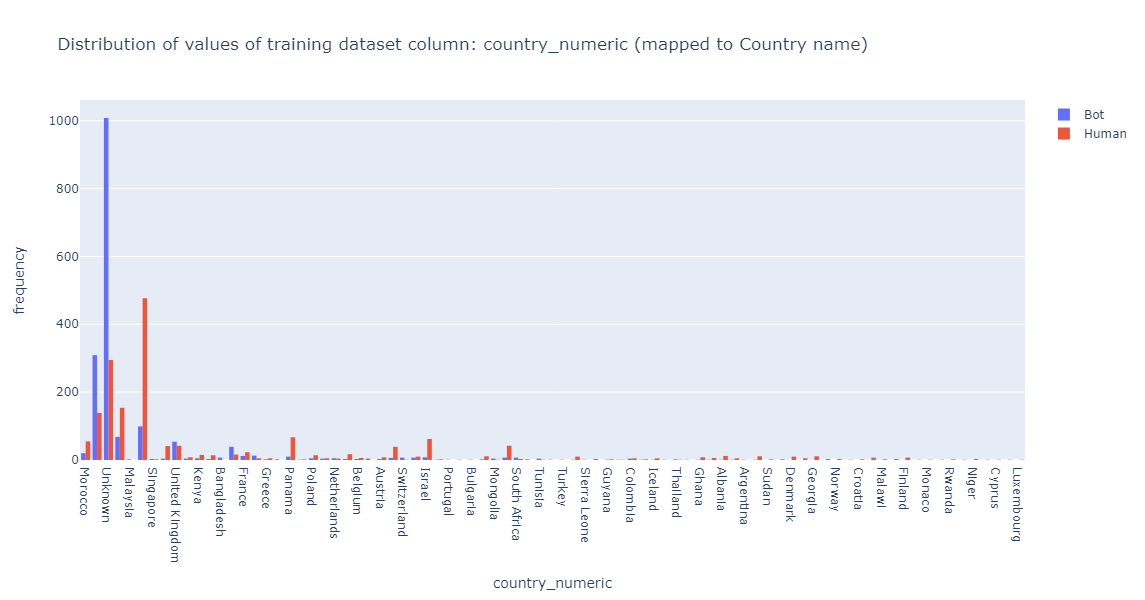

In [393]:
fig = go.Figure()
# fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=map_contries_to_str(df_reduced_outliers_country_numeric.loc[df_reduced_outliers_country_numeric['label']==1,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
# row=1, col=1
)
fig.add_trace(go.Histogram(
    x=map_contries_to_str(df_reduced_outliers_country_numeric.loc[df_reduced_outliers_country_numeric['label']==0,'country_numeric']),
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
# row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: country_numeric (mapped to Country name)',
    xaxis_title_text='country_numeric', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1200,
    height=600,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=10),
    # xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### Create merged dataframe from reduced by columns outliers dataframes

In [282]:
# train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_tweet_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_listed_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_hashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# # train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_cashtags, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_mentions, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_url_no_urls, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_descr_len, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')
# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_account_age, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

# train_data_wo_outliers = train_data_wo_outliers.merge(df_reduced_outliers_country_numeric, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [283]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_listed_count, 
              df_reduced_outliers_descr_no_hashtags, 
              df_reduced_outliers_descr_no_cashtags,
              df_reduced_outliers_descr_no_mentions,
              df_reduced_outliers_descr_no_urls,
              df_reduced_outliers_url_no_urls,
              df_reduced_outliers_descr_len,
              df_reduced_outliers_account_age,
              df_reduced_outliers_country_numeric]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [284]:
len(train_data_wo_outliers)

2546

In [285]:
train_data_wo_outliers

id  label  verified  protected  has_location  \
0     8.500171e+17    0.0       0.0        0.0           1.0   
1     1.359944e+18    0.0       0.0        0.0           1.0   
2     2.858847e+07    0.0       0.0        0.0           1.0   
3     8.897175e+07    1.0       0.0        0.0           1.0   
4     4.644165e+07    0.0       1.0        0.0           1.0   
...            ...    ...       ...        ...           ...   
2541  1.409523e+18    0.0       1.0        0.0           1.0   
2542  1.487375e+07    0.0       0.0        0.0           1.0   
2543  3.114686e+09    0.0       0.0        0.0           1.0   
2544  2.412299e+09    0.0       0.0        0.0           1.0   
2545  2.515512e+08    1.0       0.0        0.0           1.0   

      has_profile_image_url  has_pinned_tweet  followers_count  \
0                       1.0               0.0              8.0   
1                       1.0               1.0             10.0   
2                       1.0               0.0           7643.0   
3                       1.0               0.0            647.0   
4                       1.0               0.0           5104.0   
...                     ...               ...              ...   
2541                    1.0               0.0          13923.0   
2542                    1.0               0.0            275.0   
2543                    1.0               0.0           2373.0   
2544                    1.0               0.0            150.0   
2545                    1.0               0.0            117.0   

      following_count  tweet_count  listed_count  has_description  \
0                83.0          1.0           0.0              1.0   
1               107.0         16.0           0.0              1.0   
2              8529.0      22550.0         314.0              1.0   
3                48.0       2551.0          42.0              1.0   
4              2222.0      27818.0         224.0              1.0   
...               ...          ...           ...              ...   
2541            244.0        197.0         146.0              1.0   
2542           1213.0       4516.0          17.0              1.0   
2543            120.0       1674.0          29.0              1.0   
2544            524.0       5499.0           6.0              1.0   
2545           1244.0          3.0           0.0              0.0   

      descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
0                   0.0                0.0                0.0            0.0   
1                   0.0                0.0                0.0            0.0   
2                   0.0                0.0                2.0            0.0   
3                   0.0                0.0                0.0            0.0   
4                   0.0                0.0                2.0            0.0   
...                 ...                ...                ...            ...   
2541                0.0                0.0                2.0            0.0   
2542                0.0                0.0                0.0            0.0   
2543                0.0                0.0                0.0            0.0   
2544                0.0                0.0                0.0            0.0   
2545                0.0                0.0                0.0            0.0   

      url_no_urls  country_numeric  descr_len  account_age  
0             0.0            106.0       34.0       1805.0  
1             1.0             81.0      158.0        398.0  
2             1.0            236.0       74.0       4730.0  
3             1.0            139.0      106.0       4509.0  
4             1.0              1.0      136.0       4661.0  
...           ...              ...        ...          ...  
2541          1.0              1.0      158.0        261.0  
2542          1.0             81.0      122.0       5046.0  
2543          1.0            236.0       91.0       2548.0  
2544          1.0            106.0      159.0       29

#### Drop 'id' column

In [286]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [287]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  1725
Number of human users:  1725
Number of bots:  354
Number of human users:  354
Number of bots:  371
Number of human users:  371


In [288]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  1228
Number of human users:  1228
Number of bots:  354
Number of human users:  354
Number of bots:  371
Number of human users:  371


## Correlation

In [129]:
sns.set(font_scale=2)

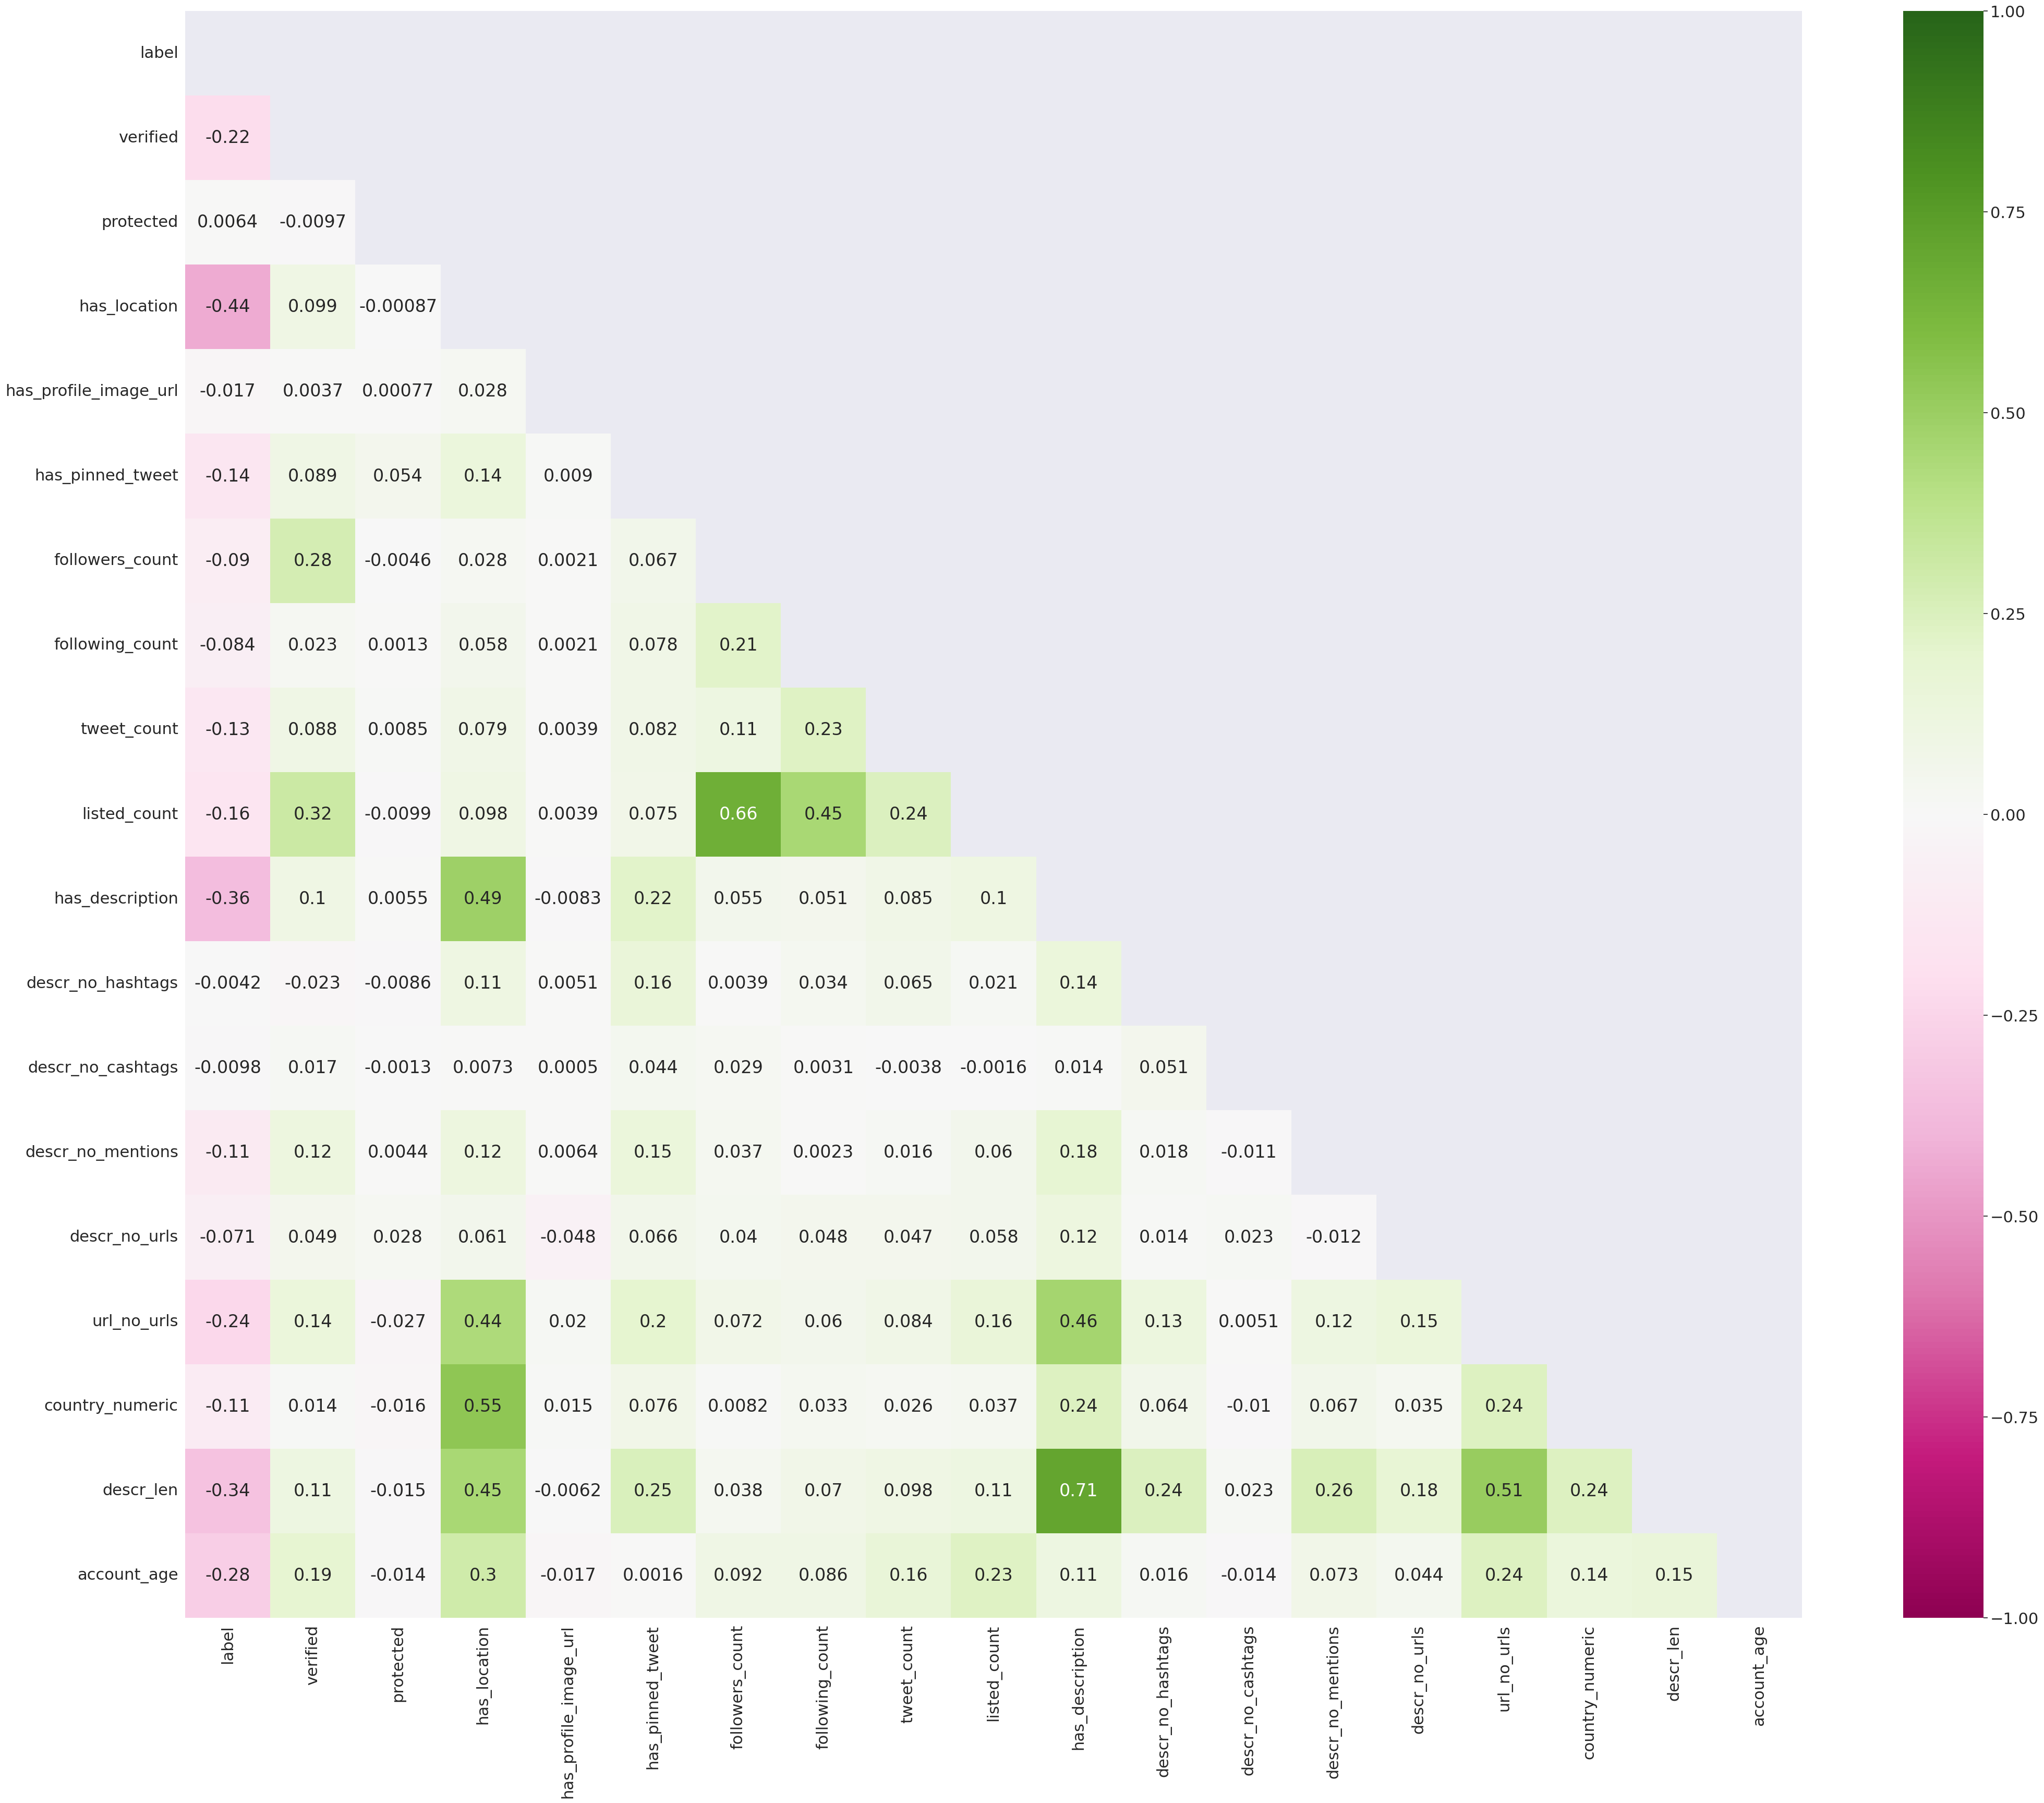

In [130]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [131]:
sns.set(font_scale=1)

In [132]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 3


[('has_description', 'descr_len', 0.7050464196942243),
 ('followers_count', 'listed_count', 0.6563838196415329),
 ('has_location', 'country_numeric', 0.5455451393130102)]

In [133]:
train_data

label  verified  protected  has_location  has_profile_image_url  \
1023    0.0       0.0        0.0           1.0                    1.0   
2435    0.0       0.0        0.0           1.0                    1.0   
3723    0.0       0.0        0.0           1.0                    1.0   
1173    0.0       0.0        0.0           1.0                    1.0   
2263    0.0       0.0        0.0           1.0                    1.0   
...     ...       ...        ...           ...                    ...   
1881    0.0       0.0        0.0           1.0                    1.0   
4861    0.0       1.0        0.0           1.0                    1.0   
1175    0.0       0.0        0.0           1.0                    1.0   
255     0.0       0.0        0.0           1.0                    1.0   
2191    0.0       0.0        0.0           1.0                    1.0   

      has_pinned_tweet  followers_count  following_count  tweet_count  \
1023               0.0              8.0             83.0          1.0   
2435               1.0           1663.0           2724.0       9876.0   
3723               1.0           1217.0           4996.0       6361.0   
1173               1.0             10.0            107.0         16.0   
2263               0.0            681.0            495.0      18157.0   
...                ...              ...              ...          ...   
1881               0.0          10949.0           9954.0       4734.0   
4861               0.0          13923.0            244.0        197.0   
1175               0.0            275.0           1213.0       4516.0   
255                0.0           2373.0            120.0       1674.0   
2191               0.0            150.0            524.0       5499.0   

      listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
1023           0.0              1.0                0.0                0.0   
2435         124.0              1.0                0.0                0.0   
3723           1.0              1.0                5.0                0.0   
1173           0.0              1.0                0.0                0.0   
2263          61.0              1.0                0.0                0.0   
...            ...              ...                ...                ...   
1881          11.0              1.0                6.0                0.0   
4861         146.0              1.0                0.0                0.0   
1175          17.0              1.0                0.0                0.0   
255           29.0              1.0                0.0                0.0   
2191           6.0              1.0                0.0                0.0   

      descr_no_mentions  descr_no_urls  url_no_urls  country_numeric  \
1023                0.0            0.0          0.0            106.0   
2435                1.0            0.0          1.0             71.0   
3723                3.0            0.0          1.0             41.0   
1173                0.0            0.0          1.0             81.0   
2263                2.0            1.0          0.0            106.0   
...                 ...            ...          ...              ...   
1881                0.0            0.0          1.0            106.0   
4861                2.0            0.0          1.0              1.0   
1175                0.0            0.0          1.0             81.0   
255                 0.0            0.0          1.0            236.0   
2191                0.0            0.0          1.0            106.0   

      descr_len  account_age  
1023       34.0       1805.0  
2435      142.0       5475.0  
3723      117.0       3335.0  
1173      158.0        398.0  
2263      131.0       4531.0  
...         ...          ...  
1881      122.0       1705.0  
4861      158.0        261.0  
1175      122.0       5046.0  
255        91.0       2548.0  
2191      159.0       2912.0  

[3450 rows x 19 columns]

In [134]:
train_data = train_data.drop(['listed_count'], axis=1)
val_data = val_data.drop(['listed_count'], axis=1)
test_data = test_data.drop(['listed_count'], axis=1)

train_data = train_data.drop(['has_description'], axis=1)
val_data = val_data.drop(['has_description'], axis=1)
test_data = test_data.drop(['has_description'], axis=1)

train_data = train_data.drop(['has_location'], axis=1)
val_data = val_data.drop(['has_location'], axis=1)
test_data = test_data.drop(['has_location'], axis=1)

### Correlation of data reduced by outliers

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [135]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

['has_profile_image_url', 'descr_no_cashtags', 'descr_no_urls']

In [136]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

#### Correlation

In [137]:
sns.set(font_scale=2)

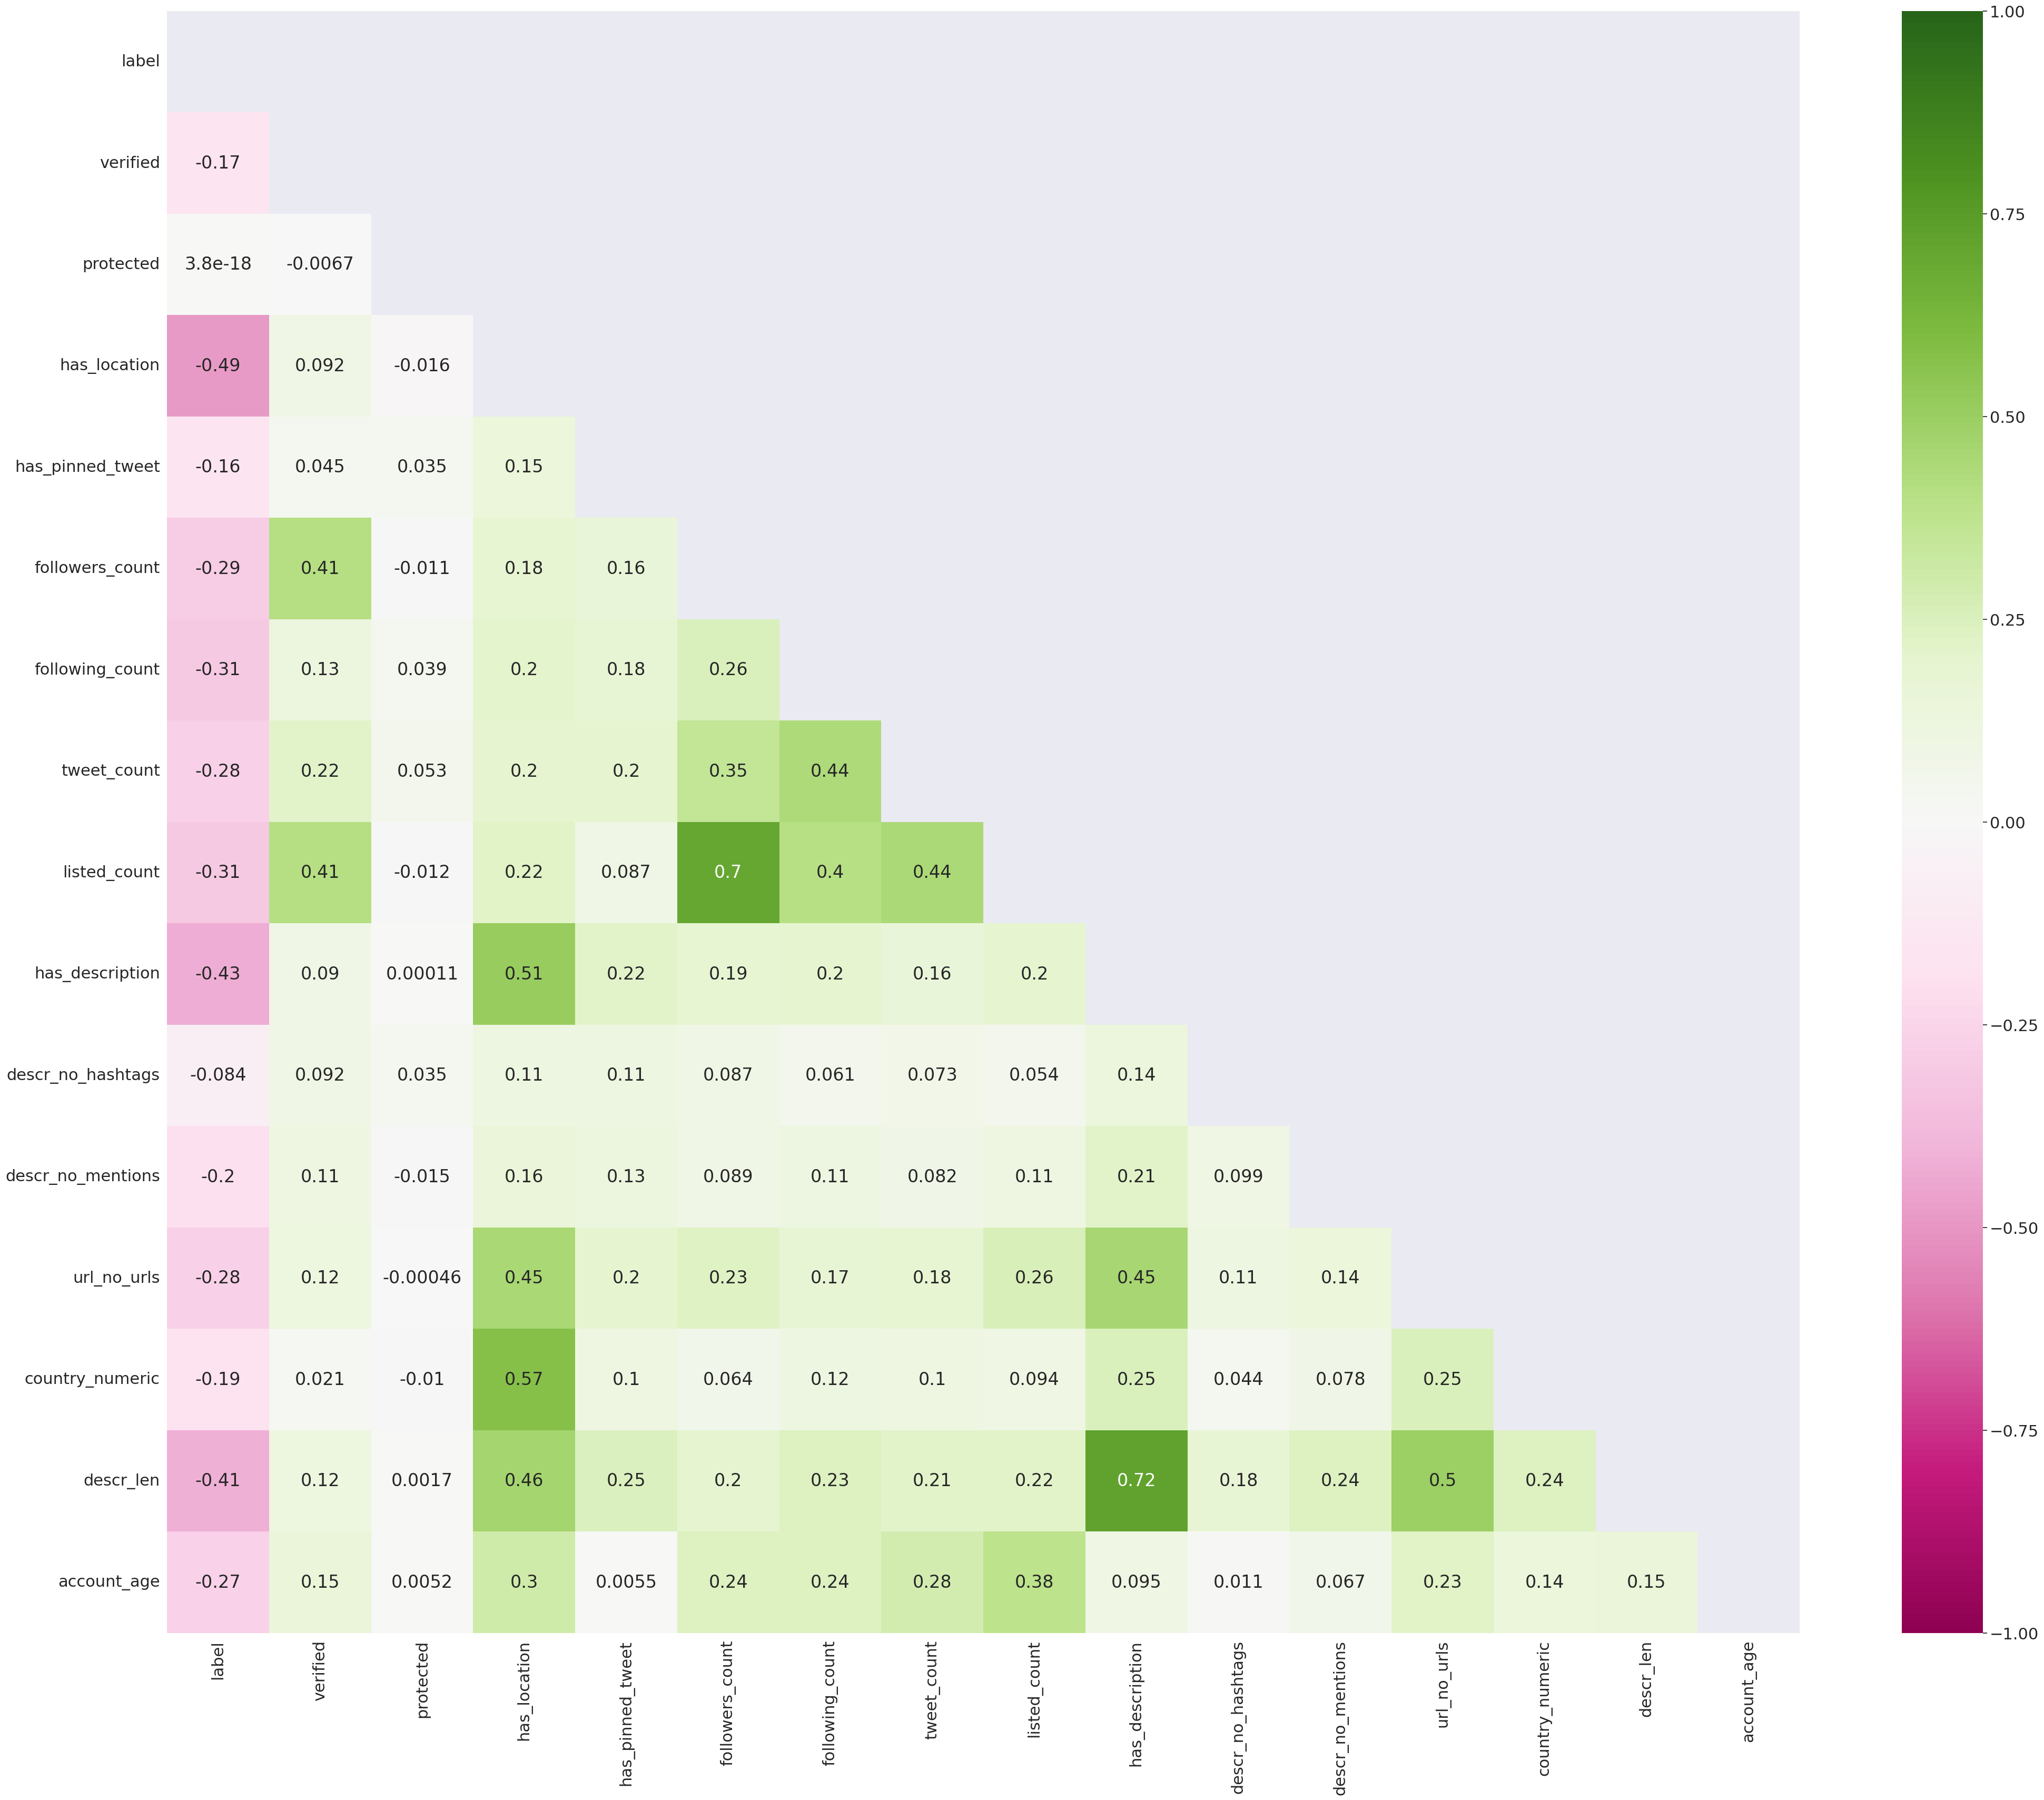

In [138]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [139]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

In [140]:
high_corr2

[('has_description', 'descr_len', 0.7192661845021395),
 ('followers_count', 'listed_count', 0.7012518117398885),
 ('has_location', 'country_numeric', 0.5712645691198295)]

In [141]:
train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description', 'has_location'], axis=1)

#### Split data for input and output

In [142]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [143]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [144]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [145]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [146]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [147]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [148]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

2023-08-23 21:35:21.844943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-23 21:35:21.845063: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-23 21:35:21.845108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (df74906de059): /proc/driver/nvidia/version does not exist
2023-08-23 21:35:21.847528: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

### batch_size=10, epochs=200

#### Create and train model

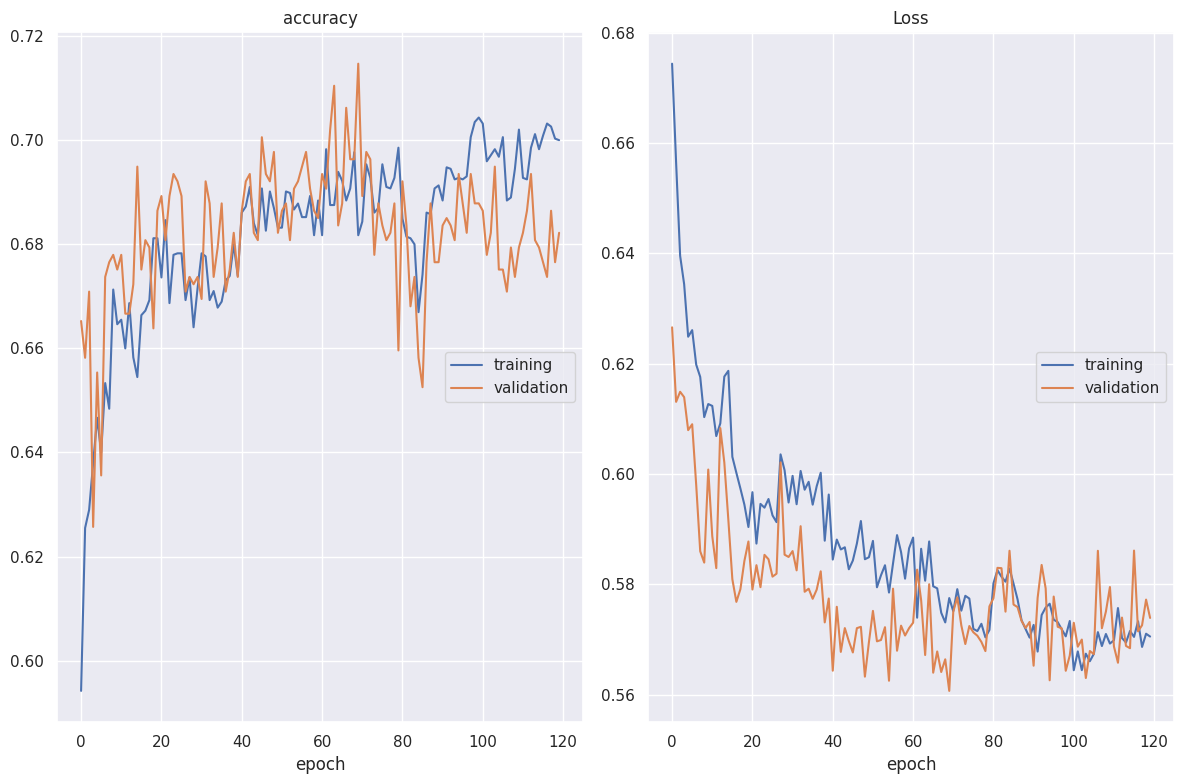

accuracy
	training         	 (min:    0.594, max:    0.704, cur:    0.700)
	validation       	 (min:    0.626, max:    0.715, cur:    0.682)
Loss
	training         	 (min:    0.564, max:    0.674, cur:    0.571)
	validation       	 (min:    0.561, max:    0.627, cur:    0.574)

Epoch 120: val_accuracy did not improve from 0.71469
345/345 [==============================] - 2s 6ms/step - loss: 0.5705 - accuracy: 0.7000 - val_loss: 0.5739 - val_accuracy: 0.6822


In [149]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v1_batch_size_10_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.6994609164420486
Precision: [0.71387283 0.68686869]
Recall: 0.7331536388140162
F1 score: 0.709257
ROC AUC: 0.699461


(0.6994609164420486,
 array([0.71387283, 0.68686869]),
 0.7331536388140162,
 0.7092568448500652,
 0.6994609164420484)

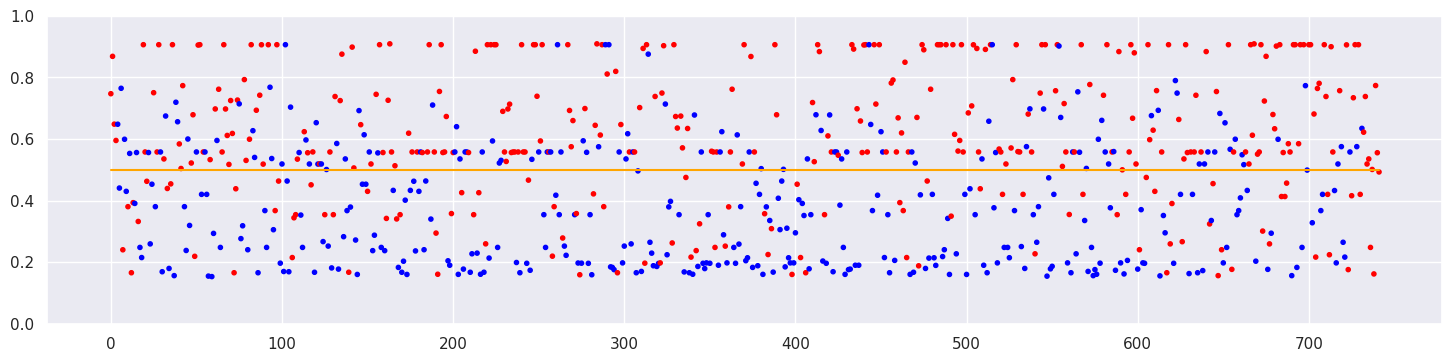

<Figure size 640x480 with 0 Axes>

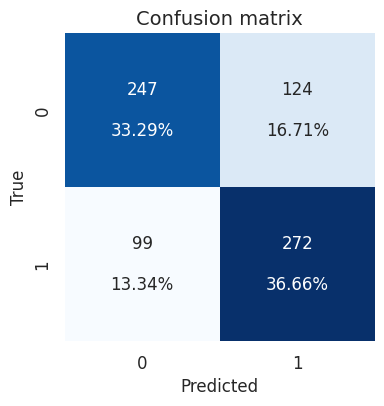

In [150]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=200

In [151]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 32)                512       
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

### Train model

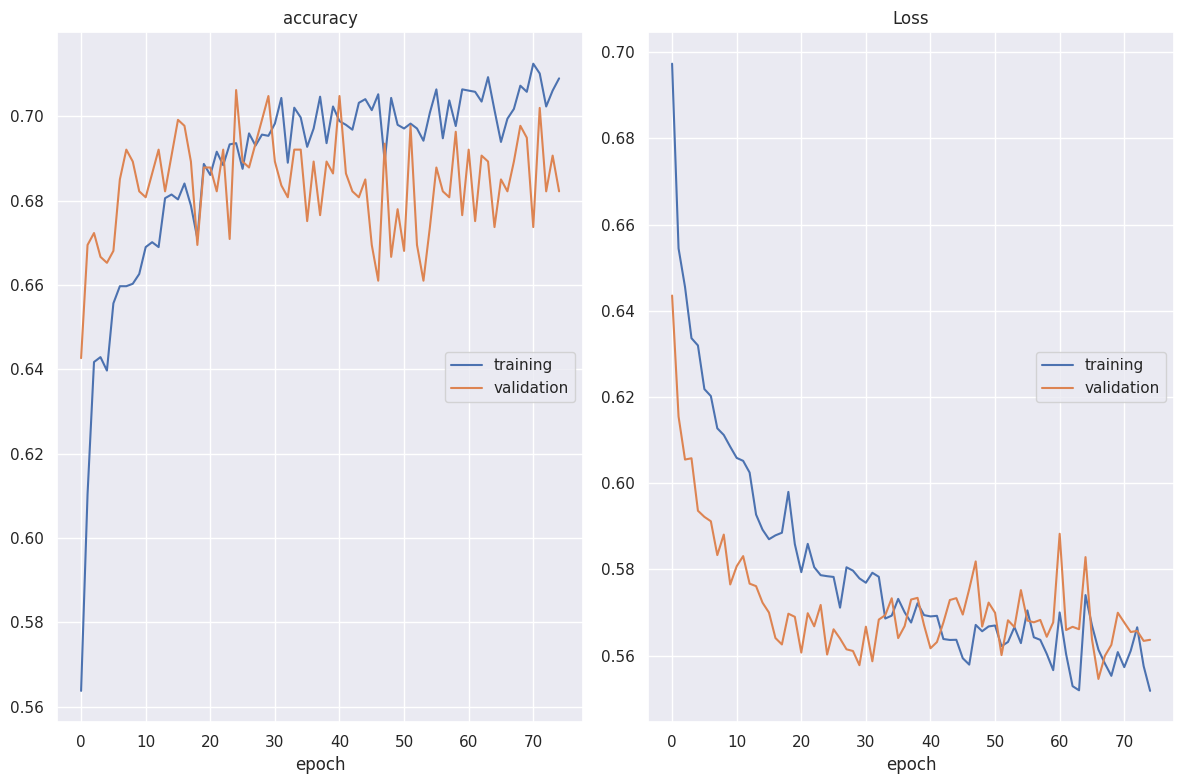

accuracy
	training         	 (min:    0.564, max:    0.712, cur:    0.709)
	validation       	 (min:    0.643, max:    0.706, cur:    0.682)
Loss
	training         	 (min:    0.552, max:    0.697, cur:    0.552)
	validation       	 (min:    0.555, max:    0.644, cur:    0.564)

Epoch 75: val_accuracy did not improve from 0.70621
69/69 [==============================] - 1s 13ms/step - loss: 0.5518 - accuracy: 0.7090 - val_loss: 0.5637 - val_accuracy: 0.6822


In [152]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v1_batch_size_50_epochs_200'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=200)

In [153]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [154]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

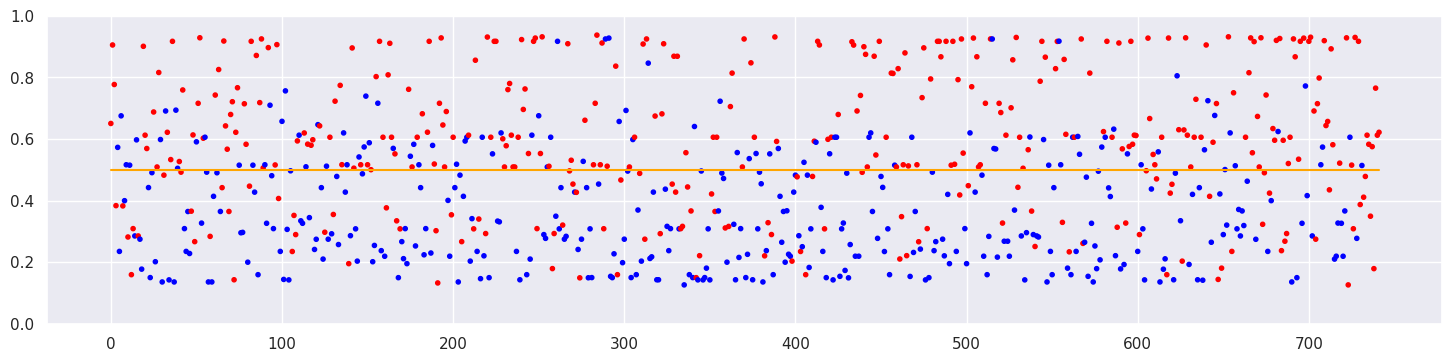

In [155]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.7196765498652291
Precision: [0.71279373 0.7270195 ]
Recall: 0.7035040431266847
F1 score: 0.715068
ROC AUC: 0.719677


(0.7196765498652291,
 array([0.71279373, 0.7270195 ]),
 0.7035040431266847,
 0.715068493150685,
 0.7196765498652292)

<Figure size 640x480 with 0 Axes>

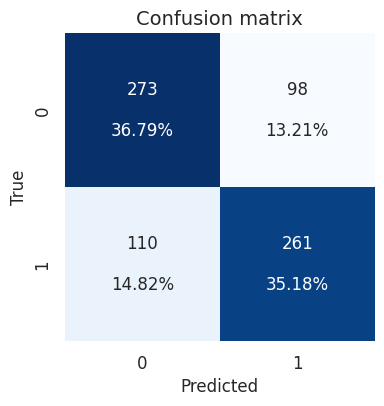

In [156]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=200

#### Create and train model

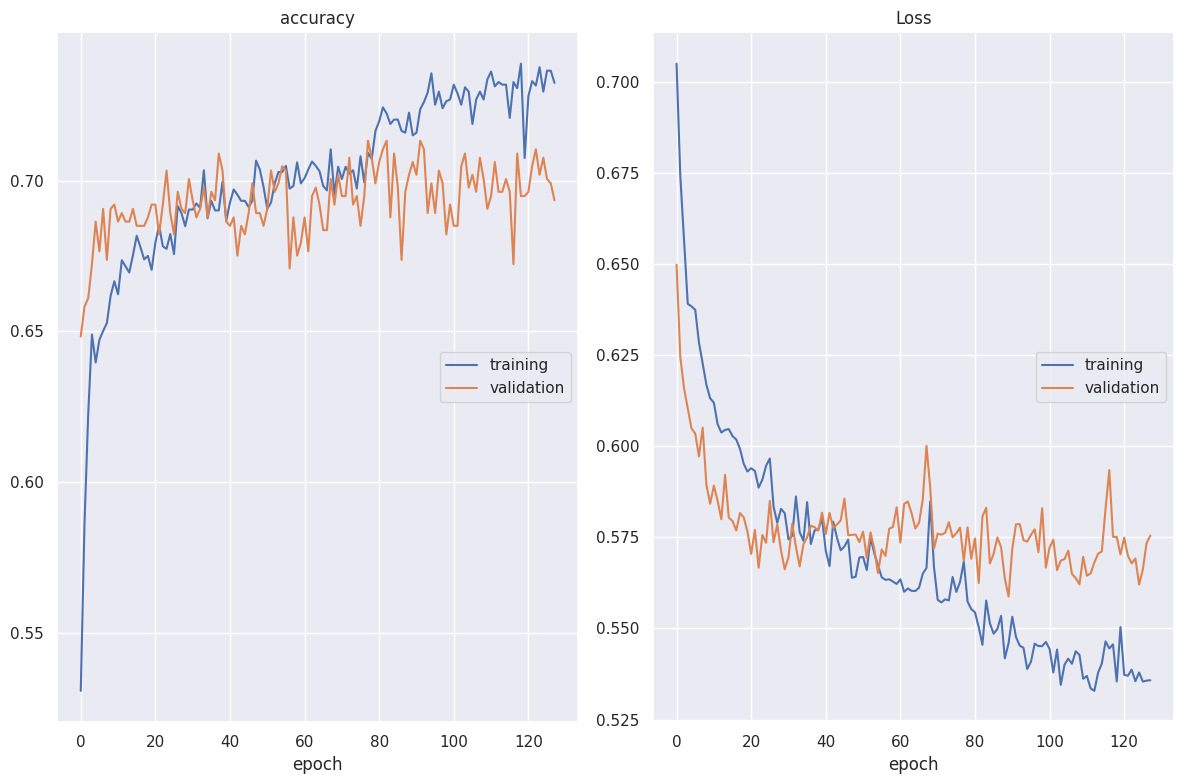

accuracy
	training         	 (min:    0.531, max:    0.739, cur:    0.732)
	validation       	 (min:    0.648, max:    0.713, cur:    0.694)
Loss
	training         	 (min:    0.533, max:    0.705, cur:    0.536)
	validation       	 (min:    0.559, max:    0.650, cur:    0.575)

Epoch 128: val_accuracy did not improve from 0.71328
35/35 [==============================] - 1s 21ms/step - loss: 0.5358 - accuracy: 0.7325 - val_loss: 0.5755 - val_accuracy: 0.6935


In [157]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v1_batch_size_100_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.7466307277628033
Precision: [0.73164557 0.76368876]
Recall: 0.7142857142857143
F1 score: 0.738162
ROC AUC: 0.746631


(0.7466307277628033,
 array([0.73164557, 0.76368876]),
 0.7142857142857143,
 0.7381615598885793,
 0.7466307277628034)

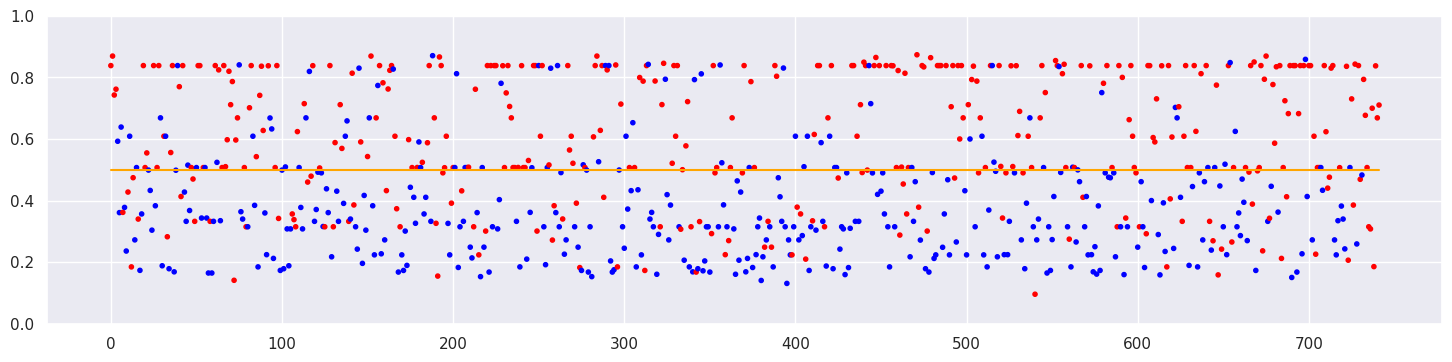

<Figure size 640x480 with 0 Axes>

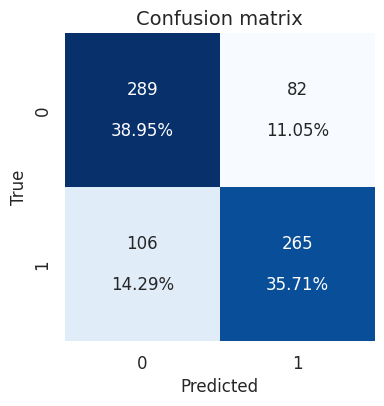

In [158]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=200

#### Create and train model

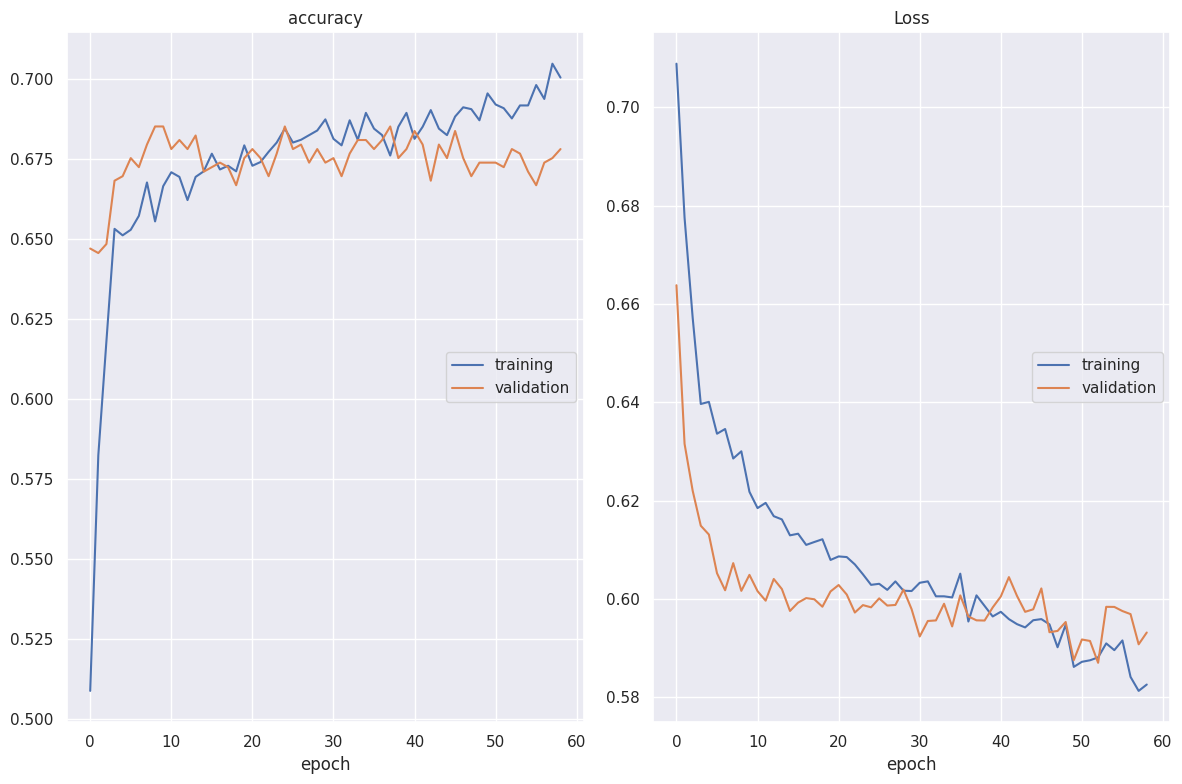

accuracy
	training         	 (min:    0.509, max:    0.705, cur:    0.700)
	validation       	 (min:    0.645, max:    0.685, cur:    0.678)
Loss
	training         	 (min:    0.581, max:    0.709, cur:    0.583)
	validation       	 (min:    0.587, max:    0.664, cur:    0.593)

Epoch 59: val_accuracy did not improve from 0.68503
23/23 [==============================] - 1s 54ms/step - loss: 0.5826 - accuracy: 0.7003 - val_loss: 0.5932 - val_accuracy: 0.6780


In [159]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v1_batch_size_150_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.6940700808625337
Precision: [0.71686747 0.67560976]
Recall: 0.7466307277628033
F1 score: 0.709347
ROC AUC: 0.694070


(0.6940700808625337,
 array([0.71686747, 0.67560976]),
 0.7466307277628033,
 0.7093469910371321,
 0.6940700808625339)

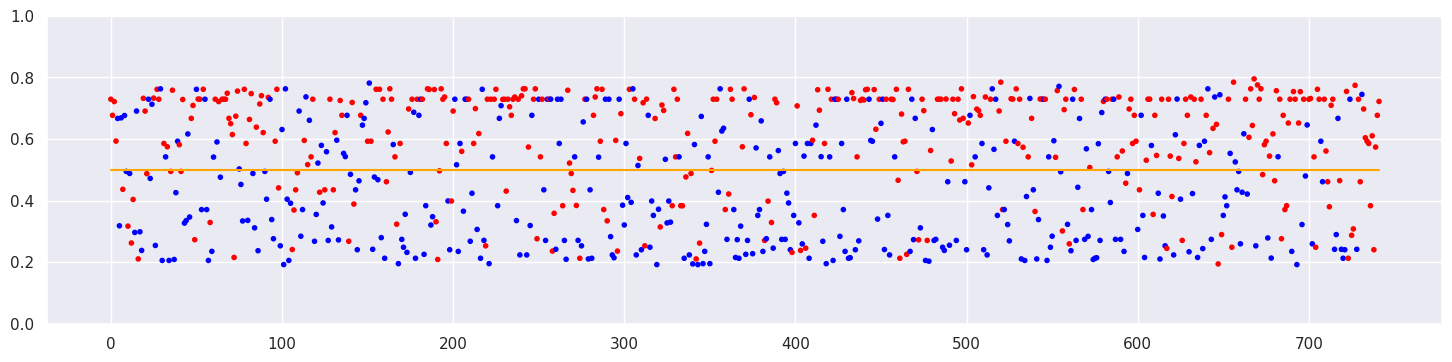

<Figure size 640x480 with 0 Axes>

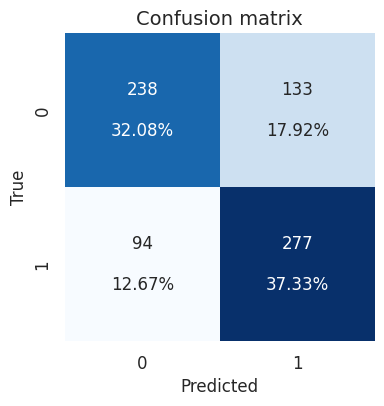

In [160]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=200

#### Create and train model

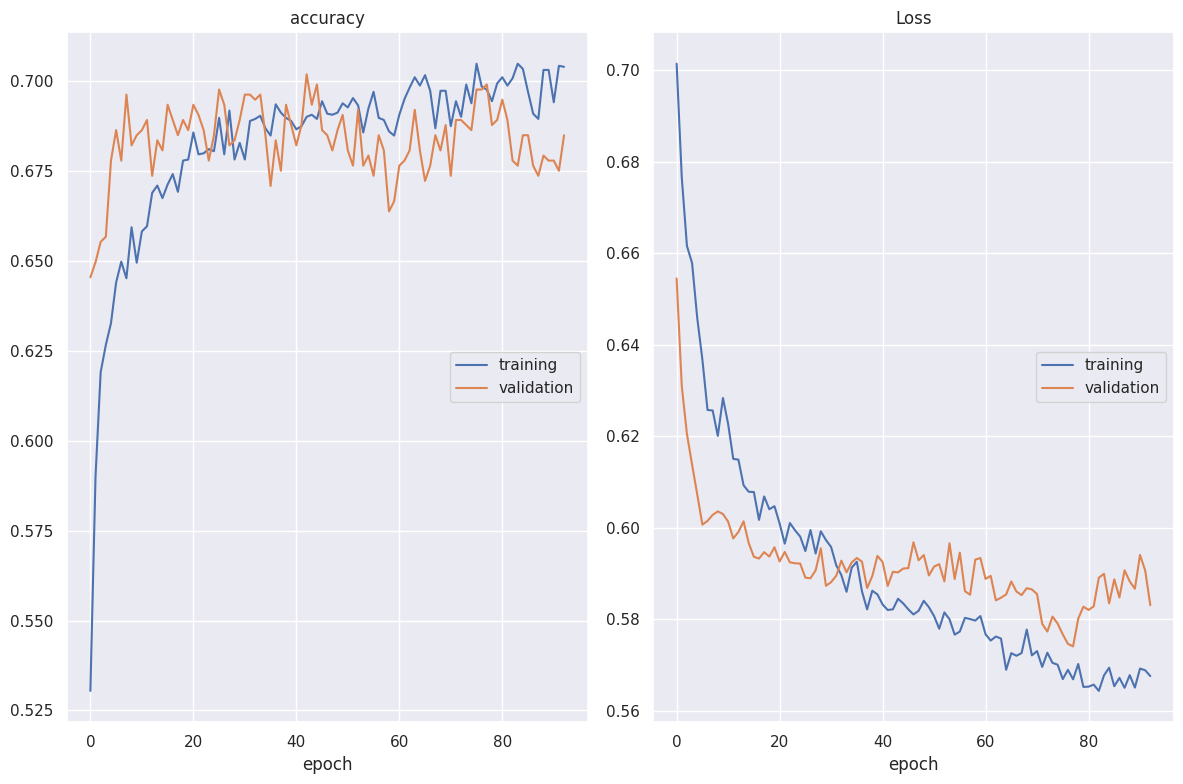

accuracy
	training         	 (min:    0.530, max:    0.705, cur:    0.704)
	validation       	 (min:    0.645, max:    0.702, cur:    0.685)
Loss
	training         	 (min:    0.564, max:    0.701, cur:    0.568)
	validation       	 (min:    0.574, max:    0.655, cur:    0.583)

Epoch 93: val_accuracy did not improve from 0.70198
18/18 [==============================] - 1s 38ms/step - loss: 0.5676 - accuracy: 0.7041 - val_loss: 0.5831 - val_accuracy: 0.6850


In [161]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v1_batch_size_200_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.7035040431266847
Precision: [0.71388102 0.6940874 ]
Recall: 0.7277628032345014
F1 score: 0.710526
ROC AUC: 0.703504


(0.7035040431266847,
 array([0.71388102, 0.6940874 ]),
 0.7277628032345014,
 0.7105263157894737,
 0.7035040431266847)

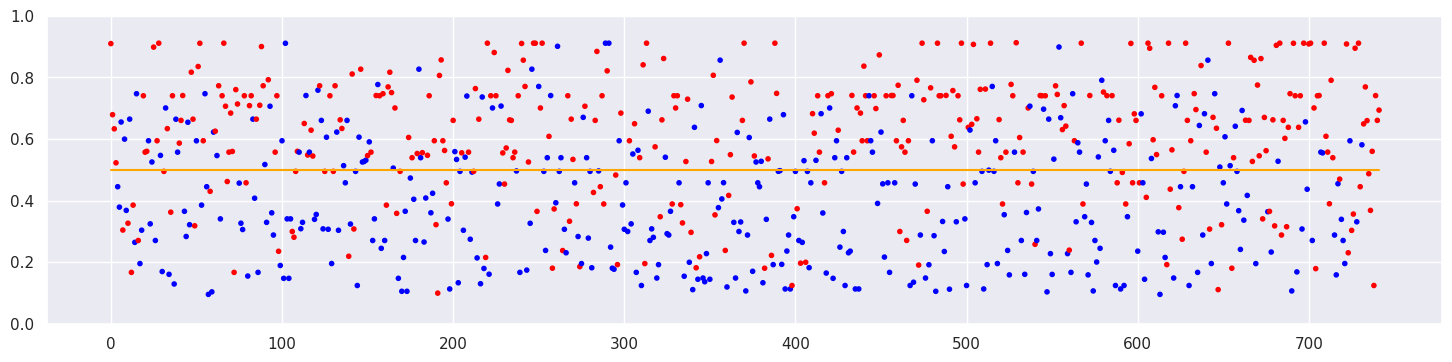

<Figure size 640x480 with 0 Axes>

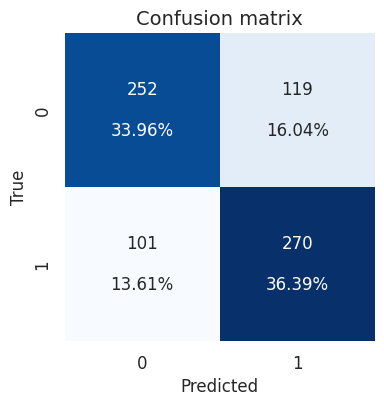

In [162]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=200

#### Create and train model

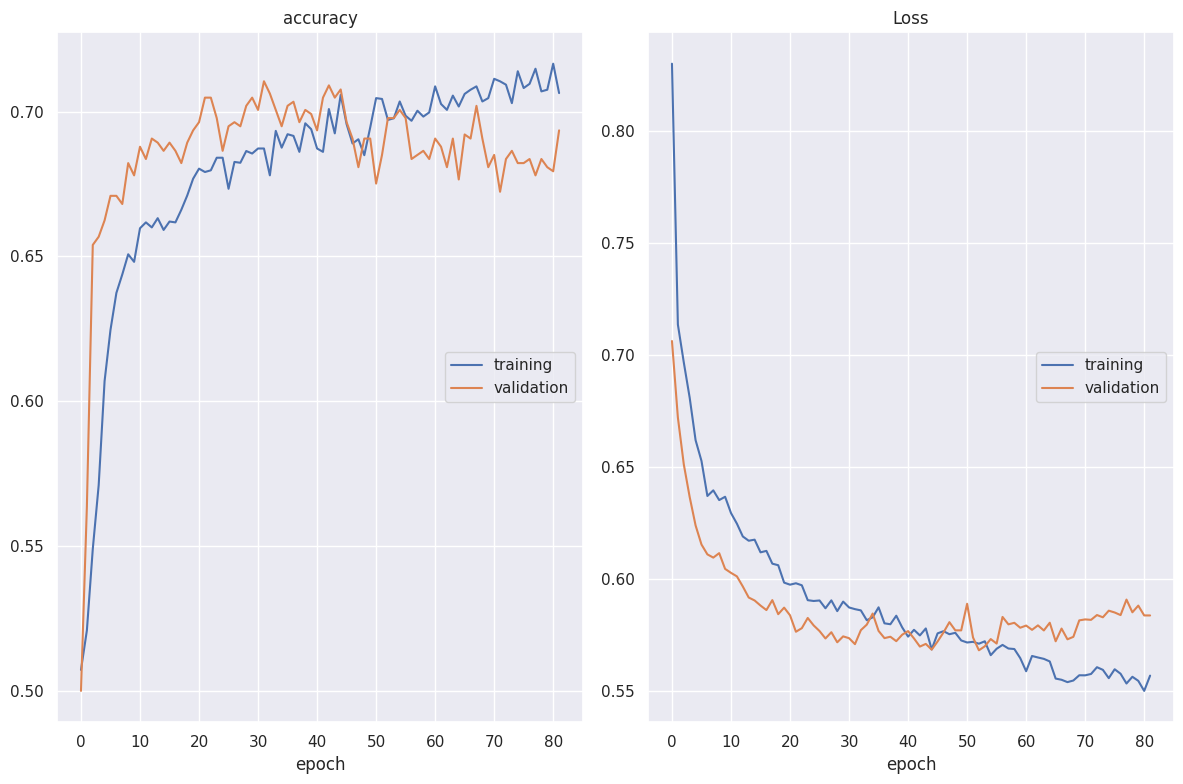

accuracy
	training         	 (min:    0.507, max:    0.717, cur:    0.706)
	validation       	 (min:    0.500, max:    0.710, cur:    0.694)
Loss
	training         	 (min:    0.550, max:    0.830, cur:    0.557)
	validation       	 (min:    0.568, max:    0.706, cur:    0.584)

Epoch 82: val_accuracy did not improve from 0.71045
14/14 [==============================] - 1s 53ms/step - loss: 0.5567 - accuracy: 0.7064 - val_loss: 0.5836 - val_accuracy: 0.6935


In [163]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v1_batch_size_250_epochs_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.7142857142857143
Precision: [0.71087533 0.71780822]
Recall: 0.706199460916442
F1 score: 0.711957
ROC AUC: 0.714286


(0.7142857142857143,
 array([0.71087533, 0.71780822]),
 0.706199460916442,
 0.7119565217391305,
 0.7142857142857143)

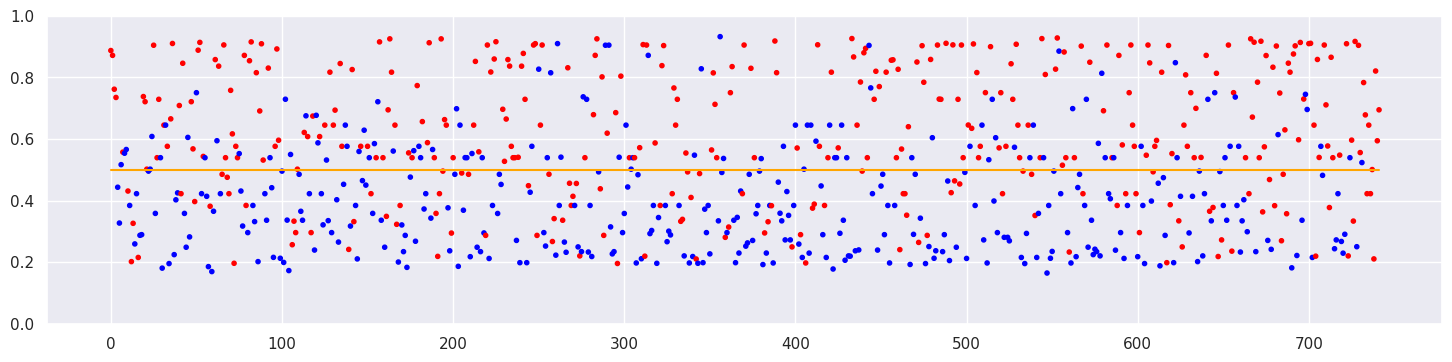

<Figure size 640x480 with 0 Axes>

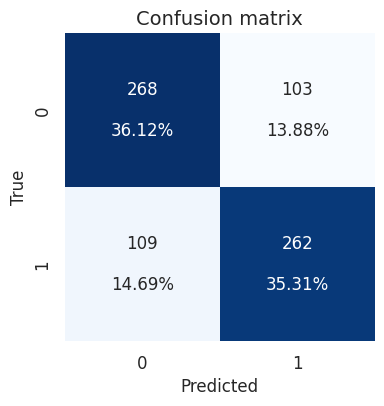

In [164]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=200

#### Create and train model

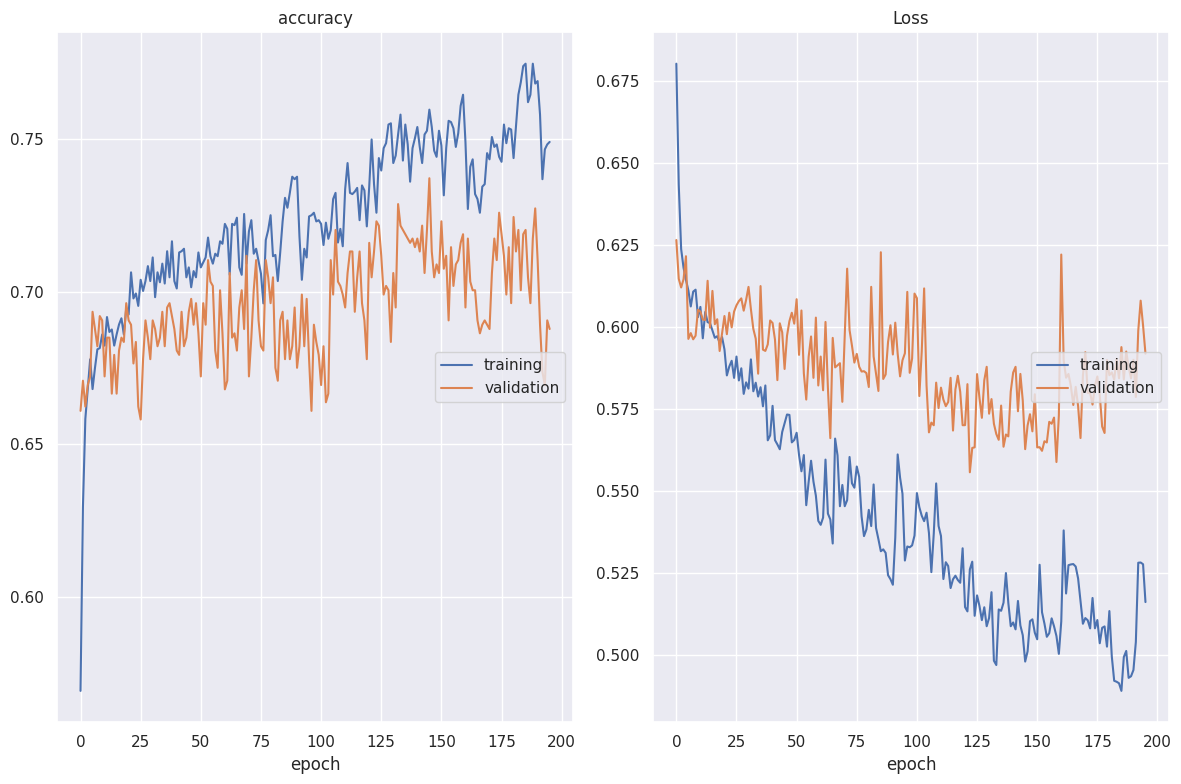

accuracy
	training         	 (min:    0.569, max:    0.775, cur:    0.749)
	validation       	 (min:    0.658, max:    0.737, cur:    0.688)
Loss
	training         	 (min:    0.489, max:    0.680, cur:    0.516)
	validation       	 (min:    0.556, max:    0.627, cur:    0.592)

Epoch 196: val_accuracy did not improve from 0.73729
246/246 [==============================] - 1s 6ms/step - loss: 0.5162 - accuracy: 0.7492 - val_loss: 0.5920 - val_accuracy: 0.6879


In [165]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_10_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=200)

#### Prediction and results

Accuracy: 0.7223719676549866
Precision: [0.69689737 0.75541796]
Recall: 0.6576819407008087
F1 score: 0.703170
ROC AUC: 0.722372


(0.7223719676549866,
 array([0.69689737, 0.75541796]),
 0.6576819407008087,
 0.7031700288184438,
 0.7223719676549865)

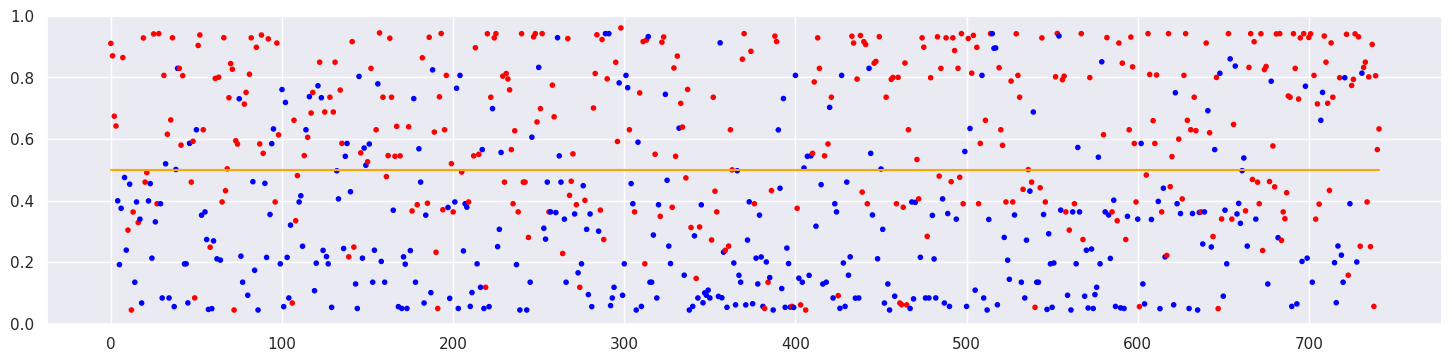

<Figure size 640x480 with 0 Axes>

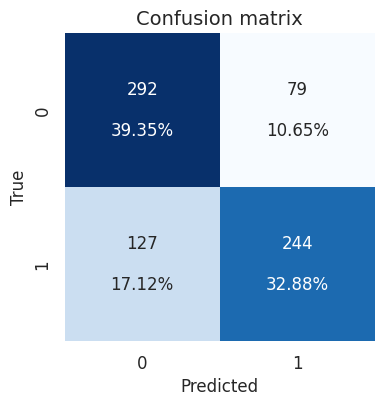

In [166]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=200

#### Create and train model

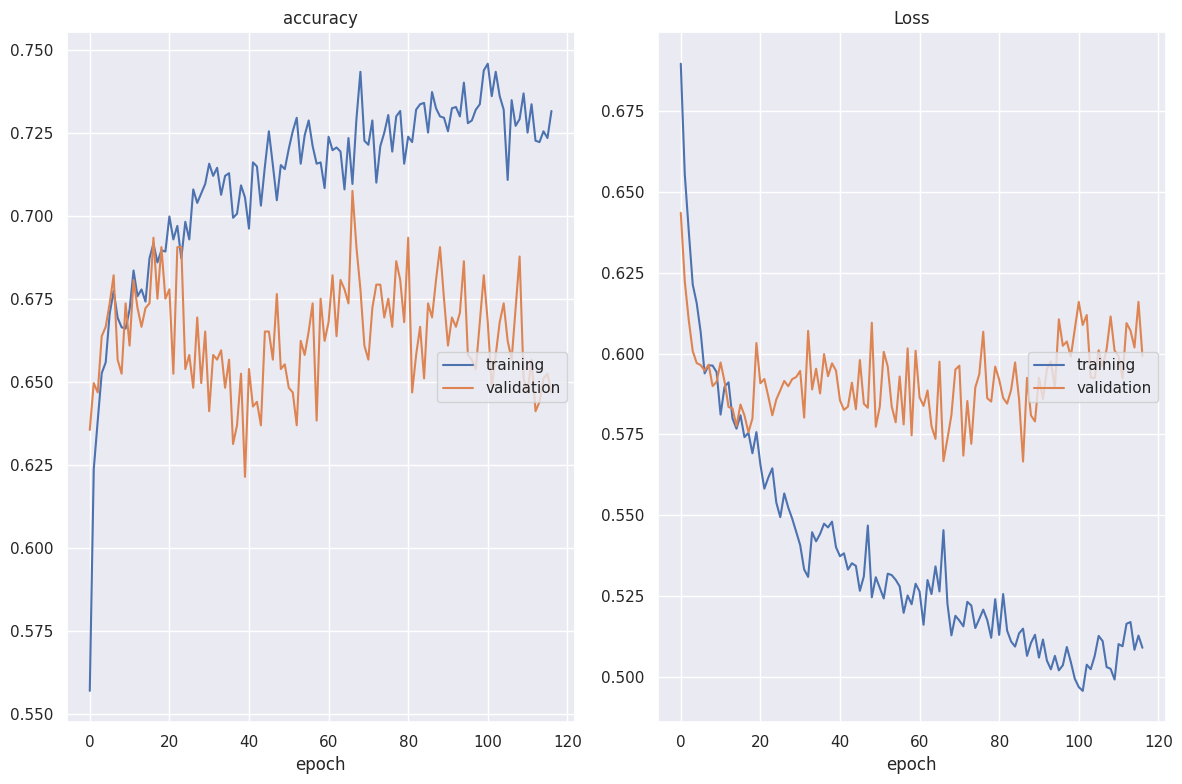

accuracy
	training         	 (min:    0.557, max:    0.746, cur:    0.732)
	validation       	 (min:    0.621, max:    0.708, cur:    0.647)
Loss
	training         	 (min:    0.496, max:    0.690, cur:    0.509)
	validation       	 (min:    0.567, max:    0.644, cur:    0.599)

Epoch 117: val_accuracy did not improve from 0.70763
50/50 [==============================] - 1s 26ms/step - loss: 0.5090 - accuracy: 0.7317 - val_loss: 0.5992 - val_accuracy: 0.6469


In [167]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_50_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=200)

#### Prediction and results

Accuracy: 0.7088948787061995
Precision: [0.69922879 0.71954674]
Recall: 0.6846361185983828
F1 score: 0.701657
ROC AUC: 0.708895


(0.7088948787061995,
 array([0.69922879, 0.71954674]),
 0.6846361185983828,
 0.7016574585635359,
 0.7088948787061995)

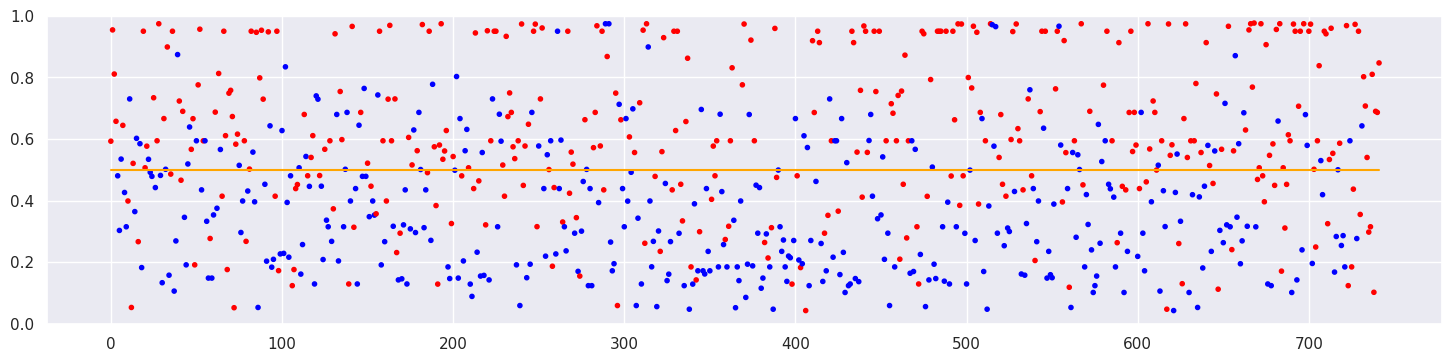

<Figure size 640x480 with 0 Axes>

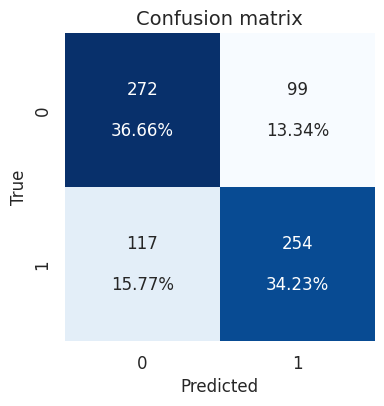

In [168]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=200

#### Create and train model

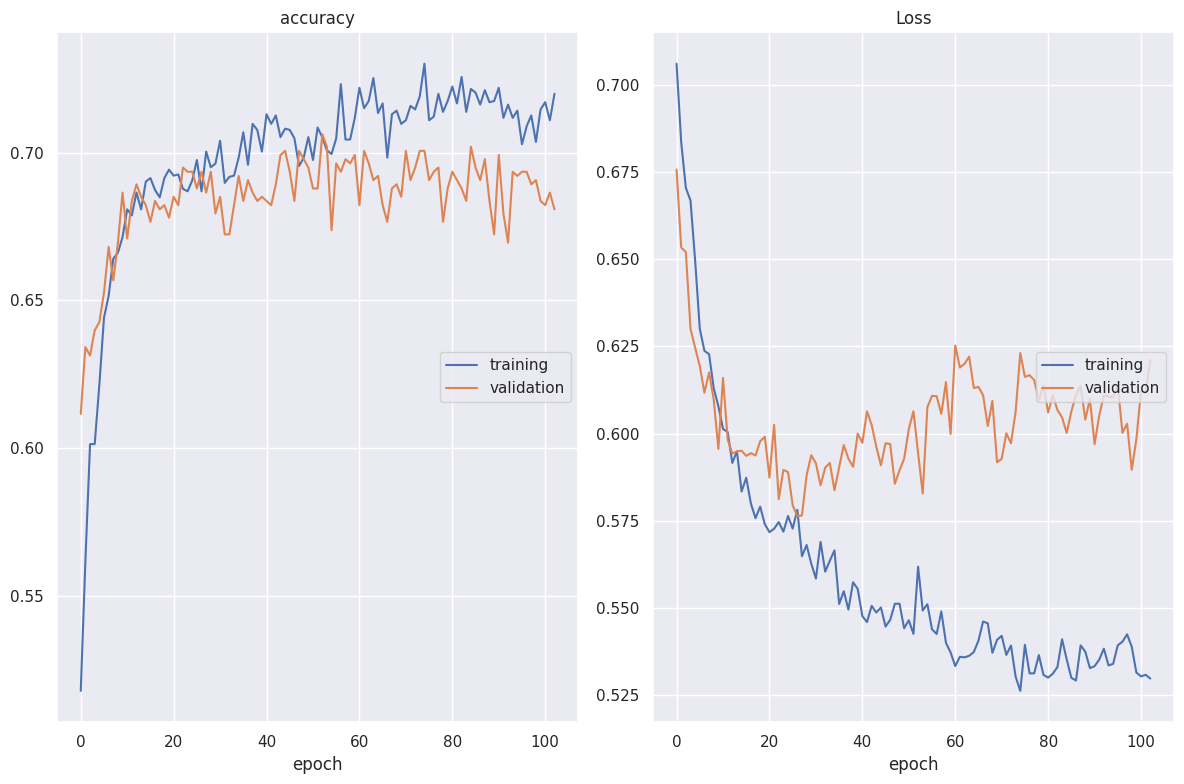

accuracy
	training         	 (min:    0.518, max:    0.730, cur:    0.720)
	validation       	 (min:    0.612, max:    0.706, cur:    0.681)
Loss
	training         	 (min:    0.526, max:    0.706, cur:    0.530)
	validation       	 (min:    0.576, max:    0.676, cur:    0.621)

Epoch 103: val_accuracy did not improve from 0.70621
25/25 [==============================] - 1s 27ms/step - loss: 0.5297 - accuracy: 0.7199 - val_loss: 0.6211 - val_accuracy: 0.6808


In [169]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_100_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=200)

#### Prediction and results

Accuracy: 0.706199460916442
Precision: [0.70619946 0.70619946]
Recall: 0.706199460916442
F1 score: 0.706199
ROC AUC: 0.706199


(0.706199460916442,
 array([0.70619946, 0.70619946]),
 0.706199460916442,
 0.706199460916442,
 0.7061994609164421)

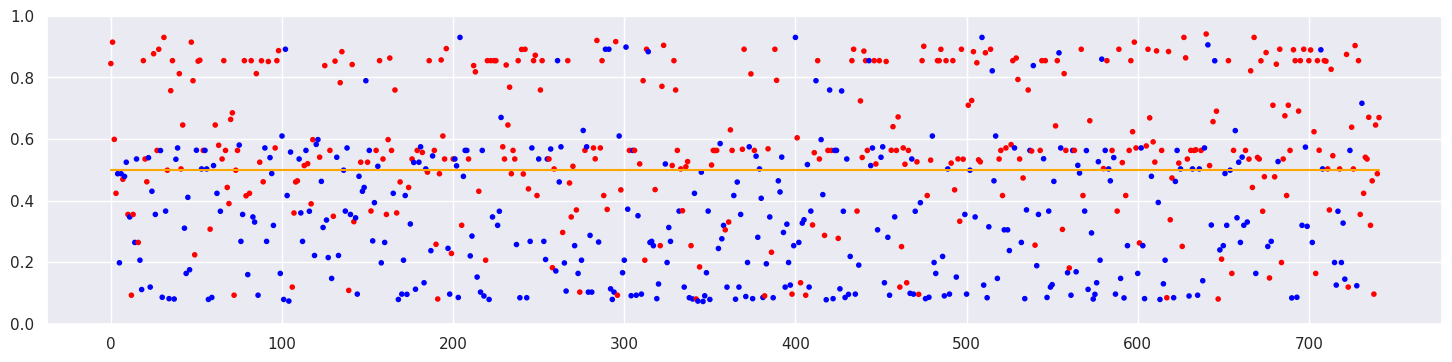

<Figure size 640x480 with 0 Axes>

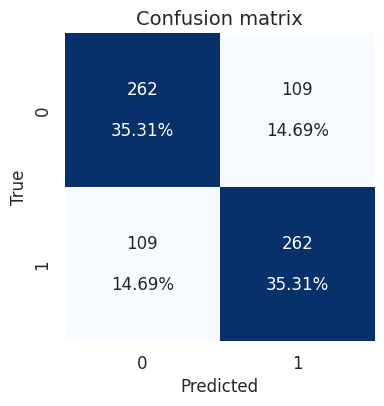

In [170]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=200

#### Create and train model

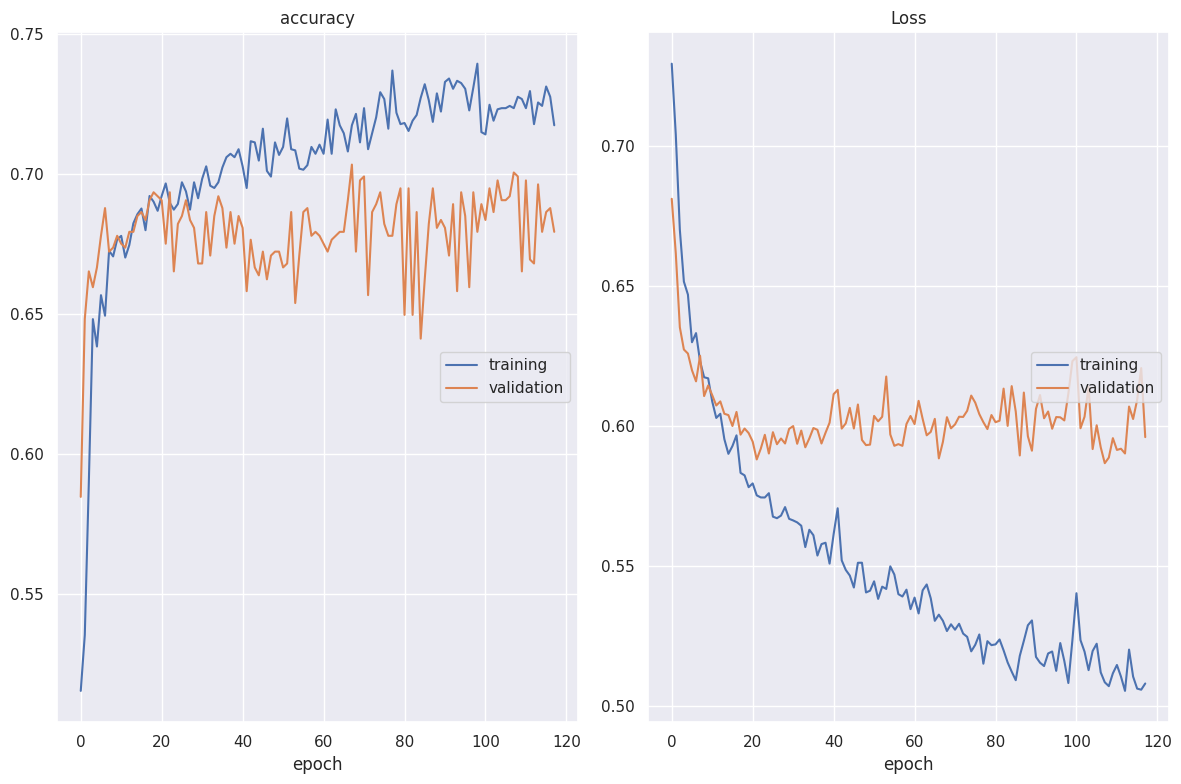

accuracy
	training         	 (min:    0.515, max:    0.739, cur:    0.717)
	validation       	 (min:    0.585, max:    0.703, cur:    0.679)
Loss
	training         	 (min:    0.505, max:    0.729, cur:    0.508)
	validation       	 (min:    0.587, max:    0.681, cur:    0.596)

Epoch 118: val_accuracy did not improve from 0.70339
17/17 [==============================] - 1s 42ms/step - loss: 0.5079 - accuracy: 0.7174 - val_loss: 0.5960 - val_accuracy: 0.6794


In [171]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_150_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=200)

#### Prediction and results

Accuracy: 0.715633423180593
Precision: [0.69512195 0.74096386]
Recall: 0.6630727762803235
F1 score: 0.699858
ROC AUC: 0.715633


(0.715633423180593,
 array([0.69512195, 0.74096386]),
 0.6630727762803235,
 0.6998577524893314,
 0.715633423180593)

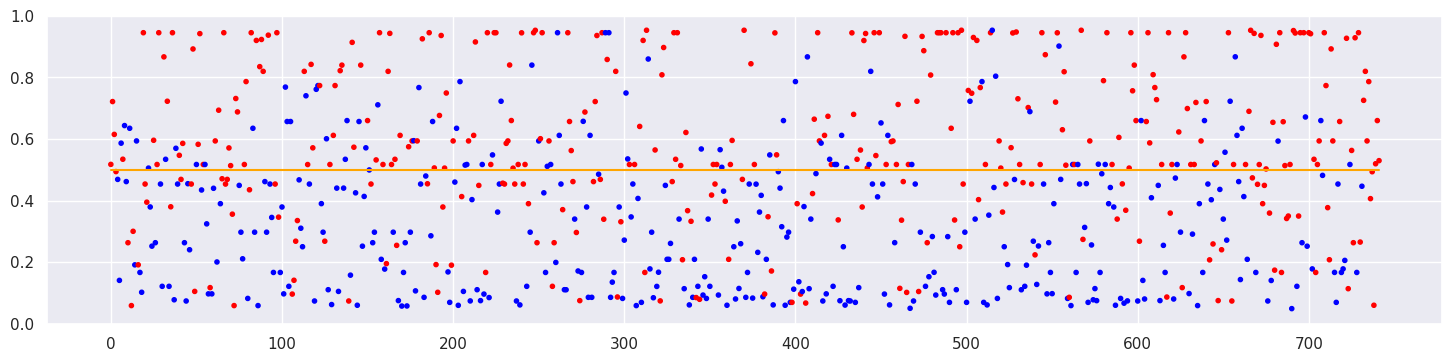

<Figure size 640x480 with 0 Axes>

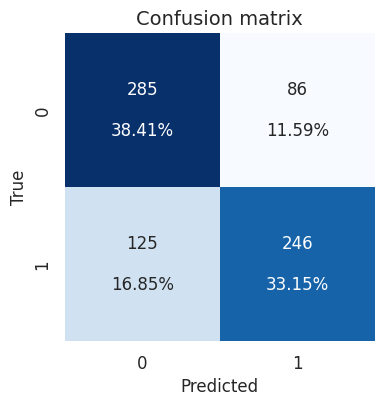

In [172]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=200

#### Create and train model

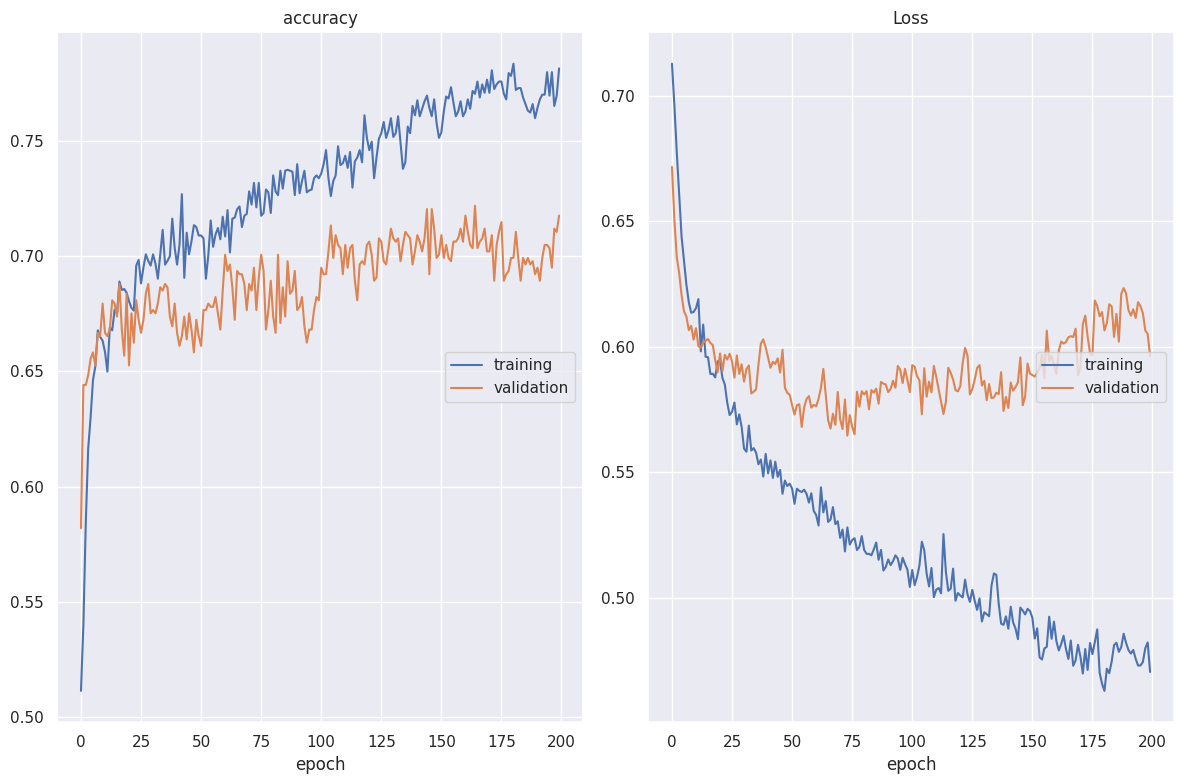

accuracy
	training         	 (min:    0.511, max:    0.783, cur:    0.781)
	validation       	 (min:    0.582, max:    0.722, cur:    0.718)
Loss
	training         	 (min:    0.463, max:    0.713, cur:    0.470)
	validation       	 (min:    0.565, max:    0.672, cur:    0.596)

Epoch 200: val_accuracy did not improve from 0.72175
13/13 [==============================] - 1s 54ms/step - loss: 0.4705 - accuracy: 0.7814 - val_loss: 0.5964 - val_accuracy: 0.7175


In [173]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_200_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=200)

#### Prediction and results

Accuracy: 0.7142857142857143
Precision: [0.6953317  0.73731343]
Recall: 0.6657681940700808
F1 score: 0.699717
ROC AUC: 0.714286


(0.7142857142857143,
 array([0.6953317 , 0.73731343]),
 0.6657681940700808,
 0.6997167138810199,
 0.7142857142857143)

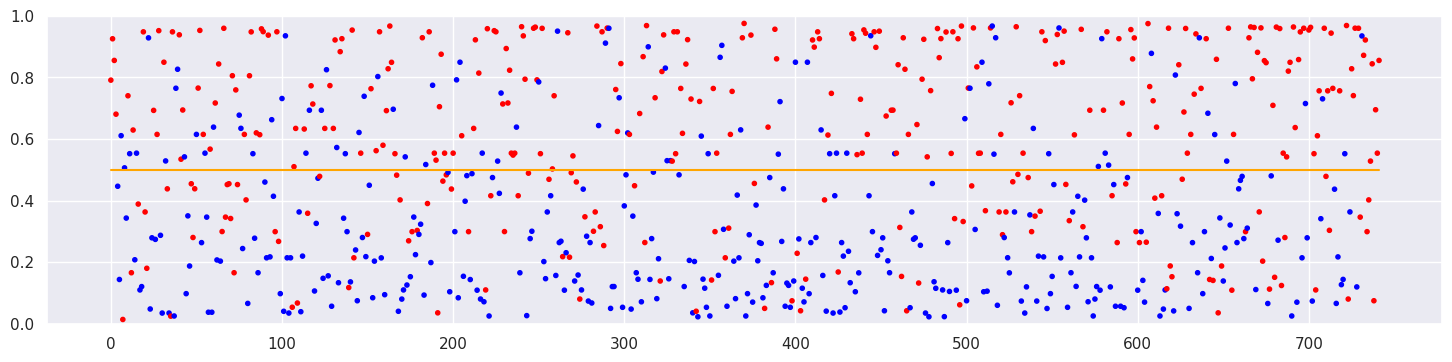

<Figure size 640x480 with 0 Axes>

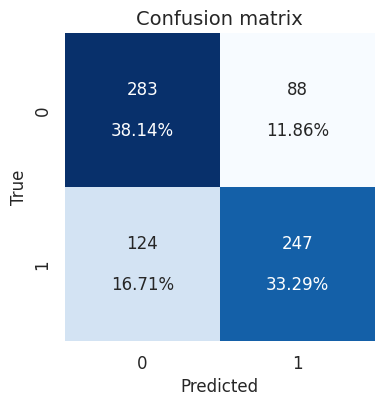

In [174]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=200

#### Create and train model

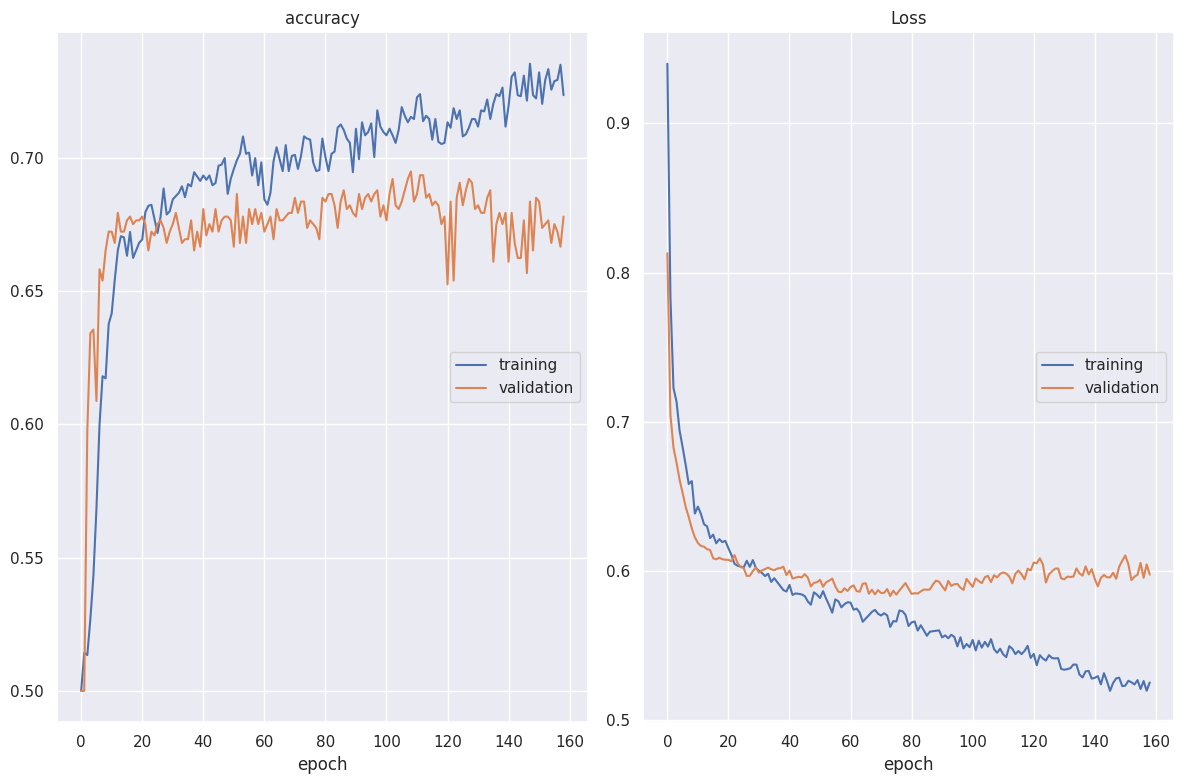

accuracy
	training         	 (min:    0.500, max:    0.735, cur:    0.724)
	validation       	 (min:    0.500, max:    0.695, cur:    0.678)
Loss
	training         	 (min:    0.520, max:    0.940, cur:    0.525)
	validation       	 (min:    0.583, max:    0.813, cur:    0.598)

Epoch 159: val_accuracy did not improve from 0.69492
10/10 [==============================] - 1s 131ms/step - loss: 0.5253 - accuracy: 0.7235 - val_loss: 0.5976 - val_accuracy: 0.6780


In [175]:
model_name = 'model_users_only_5000_with_location_mapped_to_country_1_v2_wo_outliers_batch_size_250_epochs_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=200)

#### Prediction and results

Accuracy: 0.7088948787061995
Precision: [0.71830986 0.7002584 ]
Recall: 0.7304582210242587
F1 score: 0.715040
ROC AUC: 0.708895


(0.7088948787061995,
 array([0.71830986, 0.7002584 ]),
 0.7304582210242587,
 0.7150395778364116,
 0.7088948787061995)

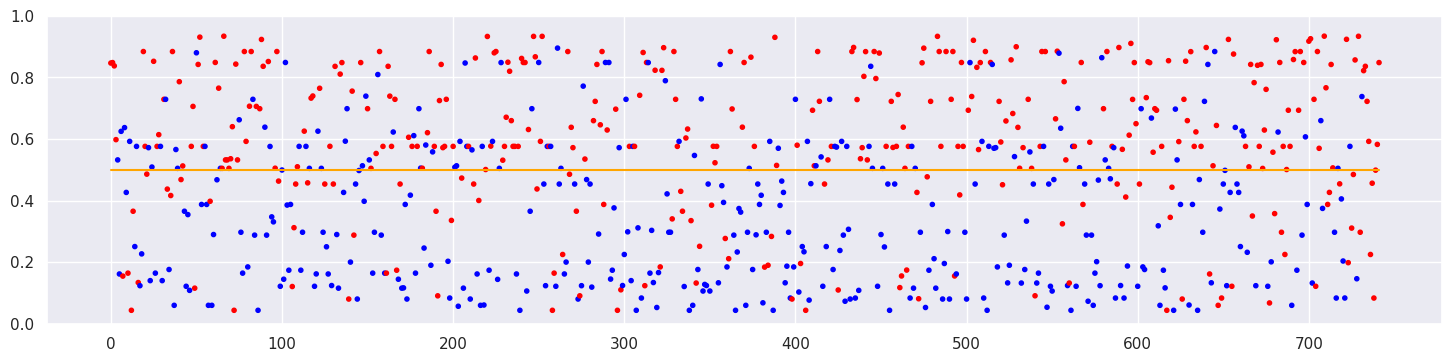

<Figure size 640x480 with 0 Axes>

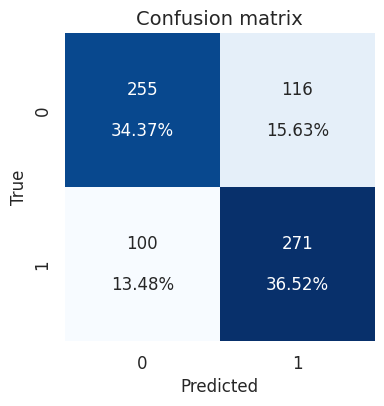

In [176]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

## SHAP (SHapley Additive exPlanations) - done for model 1 v1

In [177]:
shape = (train_X.shape[1],)
model = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())

In [178]:
explainer = shap.DeepExplainer(model, np.asarray(train_X))
shap_values = explainer.shap_values(np.asarray(train_X))

/opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:102: UserWarning:

keras is no longer supported, please use tf.keras instead.

/opt/conda/lib/python3.7/site-packages/shap/explainers/_deep/deep_tf.py:107: UserWarning:

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.

/home/jupyter/.local/lib/python3.7/site-packages/keras/backend.py:452: UserWarning:

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


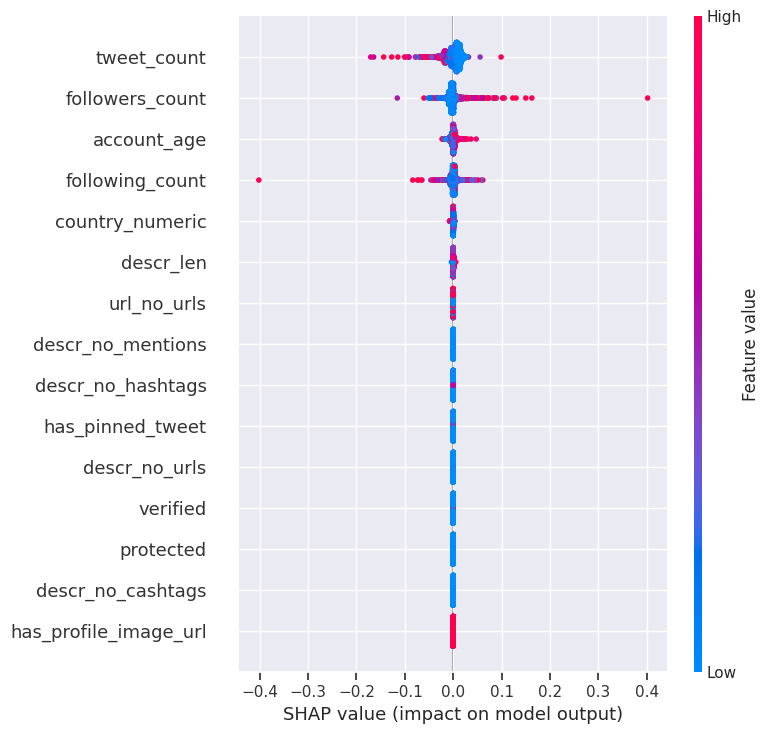

In [179]:
shap.summary_plot(shap_values[0], train_X, plot_type='dot')

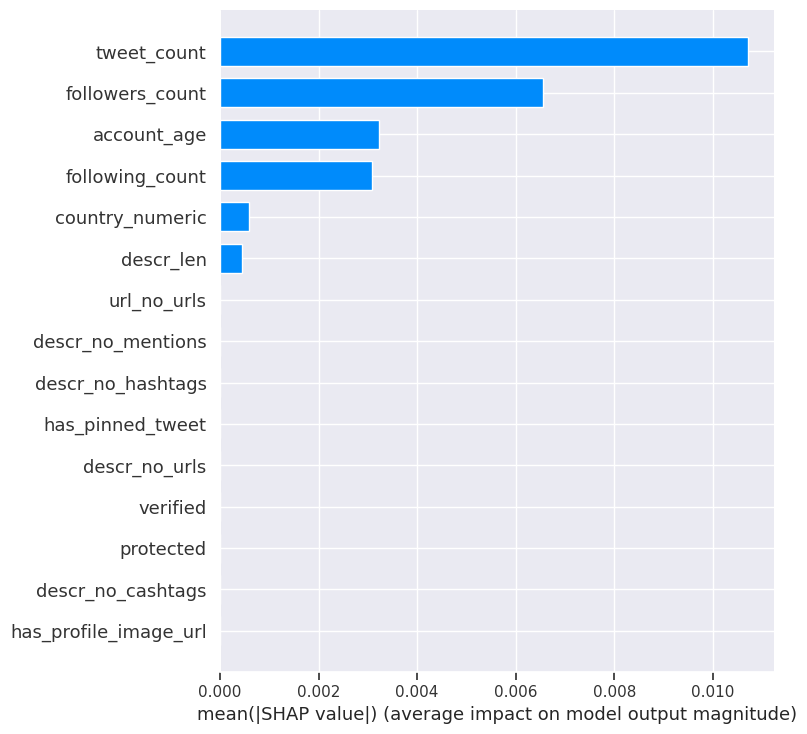

In [180]:
shap.summary_plot(shap_values[0], train_X, plot_type='bar')

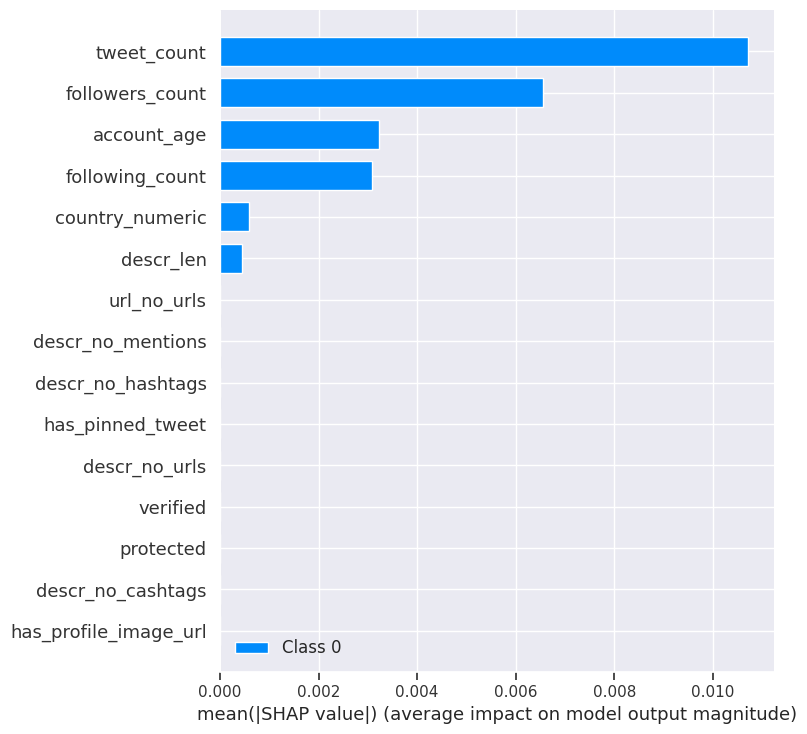

In [181]:
shap.summary_plot(shap_values, train_X, plot_type='bar')

In [182]:
# shap.dependence_plot("followers_count", shap_values[0],  train_X)